In [1]:
import pandas as pd
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Writing Assignment 3 - Exploratory Data Analysis

Libby Stephan, Leanne Beltman, Seth Bonin, Justin Coffey, Connar Gibbon

## Data Management and Cleaning Strategies

##### Data Cleaning

Because our data is taken from large datasets that have been carefully assembled for various machine learning applications, they have already been thoroughly screened for data errors by their developers prior to release. We have not encountered any issues with missing or improper values while working with our datasets.

For CelebA, the dataset consists of 202,599 facial images, which represents 10,177 unique
identities. Each of these images is annotated with 40 binary attributes and 5 landmarks per image (these landmarks indicate where facial features are in the photo). The CelebA images are in color. Examples of these binary attributes include “Wearing Hat” or “Smiling” and values are represented as either -1 (false) or 1 (true) depending on the subject. We do not have to convert any of the annotation data for this project, as it already consists of binary values.

Our Biased MNIST dataset builds on the standard MNIST dataset but provides an additional challenge for image classification by rescaling the target digit, applying a color to the digit, overlay textures, and adding colored letters to the image. The Biased MNIST dataset consists of 70,000 .jpg images and a corresponding JSON file which contains information about the image (such as the target digit, image scale and position, texture, and letter). We did not have to convert any of the annotation or image data for this project.

##### Data Reshaping

Because our CelebA dataset is so large, we frequently ran into computation issues and had to resize images prior to performing dimensionality reduction techniques. Previously, our images were too large to apply the necessary EDA techniques so we resized them to 64x64, which has made them easier to work with. The numerical data has not been adjusted.

##### Data Management

We are following the data management procedures outlined in our second writing assignment, although we have not built a model yet and are simply performing exploratory analysis on the data after it has been downloaded for this assignment.

### Methods

In this notebook, we will first examine our CelebA dataset. We will use correlation heatmaps and pairwise frequency calculations to explore which attributes frequently appear together, which may then be difficult for a neural network to distinguish when they appear independently. We will also examine the distributions of individual attributes, since attributes that are not well represented may be more frequently be misclassified by a model. Finally, we will use the PaCMAP dimensionality reduction technique to determine if any attributes are separable from one another when decomposed. Attributes that are separable may be easier for a neural network to learn, so we will look for attributes that are not easy to separate. PCA and UMAP could not be performed due to computation power restrictions.

Then, we will examine our Biased MNIST dataset using similar techniques. The biased MNIST dataset contains many varieties of the images with varying degrees of correlation between the variables within them. We will look at the datasets with correlations of 0.1, 0.5, and 0.99. We will observe distributions of individual variables, as well as using stacked bar charts to examine multivariate patterns in the datasets. Then, we will use PCA, UMAP, and PaCMAP to perform dimensionality reduction again and look for separable variables.

Our objective is to look for variables that may be underrepresented, highly correlated, and/or not easily separable via dimensionality reduction, since these may be difficult for a neural network to correctly classify.

### Dimensionality Reduction Data

The dimensionality techniques we performed are performed in separate notebooks (found on our Gitlab) and then converted to a CSV file for easier use. We are using the CSV results of dimensionality reduction to produce the plots you see in this notebook. To see and run our dimensionality reduction code, the notebooks are:

1. Capstone_PACMAP_CelebA.ipynb (https://gitlab.eecs.wsu.edu/data_424_2025/t2p4/-/blob/main/Code/EDA/Capstone_PACMAP_CelebA.ipynb?ref_type=heads)
2. Biased_MNIST_PCA_PACMAP_UMAP.ipynb (https://gitlab.eecs.wsu.edu/data_424_2025/t2p4/-/blob/main/Data/MNIST/Biased_MNIST_PCA_PACMAP_UMAP.ipynb?ref_type=heads)

## CelebA Data Exploration

In [2]:
attributes = pd.read_csv("celeba/list_attr_celeba.txt", header=1, sep="\s+") # directory may need to be changed when running

### Pearson Correlation Heatmap and Strong Correlations

Text(0.5, 1.0, 'CelebA Pearson Correlation Heatmap')

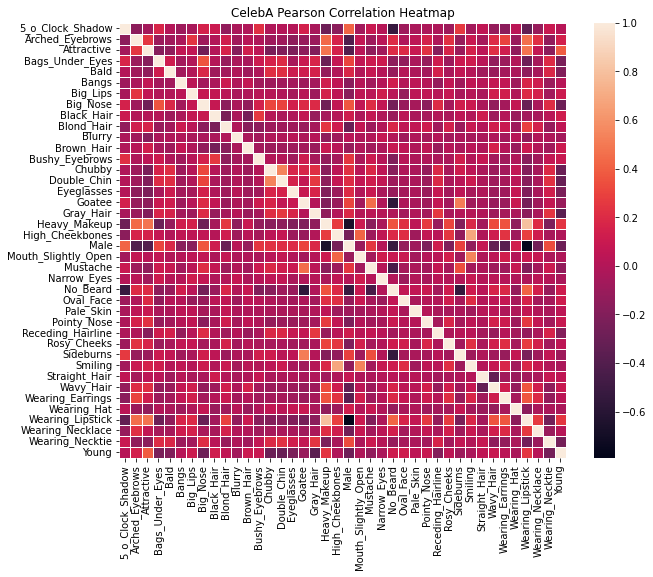

In [4]:
attribute_correlation = attributes.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(attribute_correlation, annot=False, fmt=".2f", linewidths=0.5)
plt.title("CelebA Pearson Correlation Heatmap")

In [5]:
# credit for code from https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas

def get_redundant_pairs(attributes):
    # Remove redundant diagonals (correlation with itself) and duplicate correlations
    pairs_to_drop = set()
    cols = attributes.columns
    for i in range(0, attributes.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_pos_correlations(attributes, n=5):
    # Top N strongest positive correlations
    au_corr = attributes.corr().unstack()
    labels_to_drop = get_redundant_pairs(attributes)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

def get_top_neg_correlations(attributes, n=5):
    # Top N strongest negative correlations
    au_corr = attributes.corr().unstack()
    labels_to_drop = get_redundant_pairs(attributes)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=True)
    return au_corr[0:n]

print("Top Positive Correlations Using Pearson")
print(get_top_pos_correlations(attributes, 5))
print("Top Negative Correlations Using Pearson")
print(get_top_neg_correlations(attributes, 5))

Top Positive Correlations Using Pearson
Heavy_Makeup         Wearing_Lipstick    0.801539
High_Cheekbones      Smiling             0.683497
Mouth_Slightly_Open  Smiling             0.536379
Chubby               Double_Chin         0.533713
Goatee               Sideburns           0.512893
dtype: float64
Top Negative Correlations Using Pearson
Male              Wearing_Lipstick   -0.789435
Heavy_Makeup      Male               -0.666724
Goatee            No_Beard           -0.570071
No_Beard          Sideburns          -0.543061
5_o_Clock_Shadow  No_Beard           -0.526946
dtype: float64


From the heatmap and obtaining the top positive and negative Pearson correlations among the CelebA attributes, we can get an idea of which variables are most closely correlated with one another. Features that are highly correlated may be difficult for the neural network to distinguish because they typically appear together. For example, "Heavy Makeup" and "Wearing Lipstick" have a correlation coefficient of 0.80, which indicates a strong positive correlation between them. This means that people that are wearing heavy makeup are also often wearing lipstick. Because they often appear together, it may be difficult for a neural network to distinguish heavy makeup from lipstick. This makes these two variables good candidiates for target variables for our model.

### Relative Frequencies

In [6]:
pair_frequencies = []
for i, column in enumerate(attributes.columns):
    for j, column2 in enumerate(attributes.columns):
        intersection = attributes[(attributes[column] == 1) & (attributes[column2] == 1)]
        union = attributes[(attributes[column] == 1) | (attributes[column2] == 1)]
        frequency = len(intersection) / len(union) if len(union) > 0 else 0
        pair_frequencies.append(((column, column2), frequency))

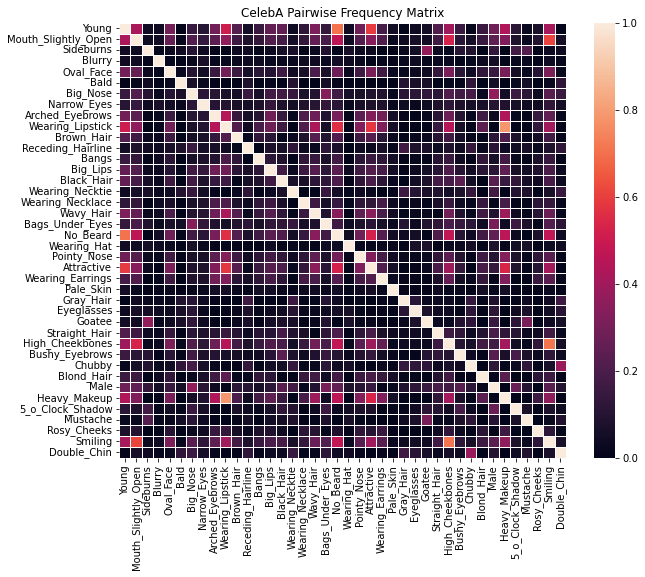

In [7]:
pairwise_dict = dict(pair_frequencies)

columns = list(set([pair[0] for pair in pairwise_dict.keys()] + [pair[1] for pair in pairwise_dict.keys()]))

correlation_matrix = pd.DataFrame(np.zeros((len(columns), len(columns))), index=columns, columns=columns)

for (col1, col2), value in pairwise_dict.items():
    correlation_matrix.loc[col1, col2] = value
    correlation_matrix.loc[col2, col1] = value

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", linewidths=0.5)
plt.title("CelebA Pairwise Frequency Matrix")
plt.show()

In [8]:
filtered_pairs = {}

for (col1, col2), freq in pair_frequencies:
    if col1 != col2:
        pair_key = tuple(sorted([col1, col2]))
        if pair_key not in filtered_pairs:
            filtered_pairs[pair_key] = freq

top_pairs = sorted(filtered_pairs.items(), key=lambda x: x[1], reverse=True)

print("Top 5 Highest Frequency Pairs:")
for pair, freq in top_pairs[:5]:
    print(f"{pair}: {freq:.4f}")

Top 5 Highest Frequency Pairs:
('Heavy_Makeup', 'Wearing_Lipstick'): 0.7841
('High_Cheekbones', 'Smiling'): 0.7111
('No_Beard', 'Young'): 0.7036
('Mouth_Slightly_Open', 'Smiling'): 0.6132
('Attractive', 'Young'): 0.5907


Again, we can see that "Heavy Makeup" and "Wearing Lipstick" often appear together. This time, we used a different metric (the intersection of two variables divided by their union, which gives a frequency). We can see that heavy makeup and lipstick frequently appear in photos together, which is in agreement with our findings using the Pearson correlation metric. This further boosts the idea that these two variables may be difficult for a neural network to distinguish because they are often seen together. "High Cheekbones" and "Smiling" also appear in the top 5 for both Pearson and relative frequency metrics, indicating that they could also be difficult to distinguish and good target variable candidates.

### Exploring Attribute Frequency

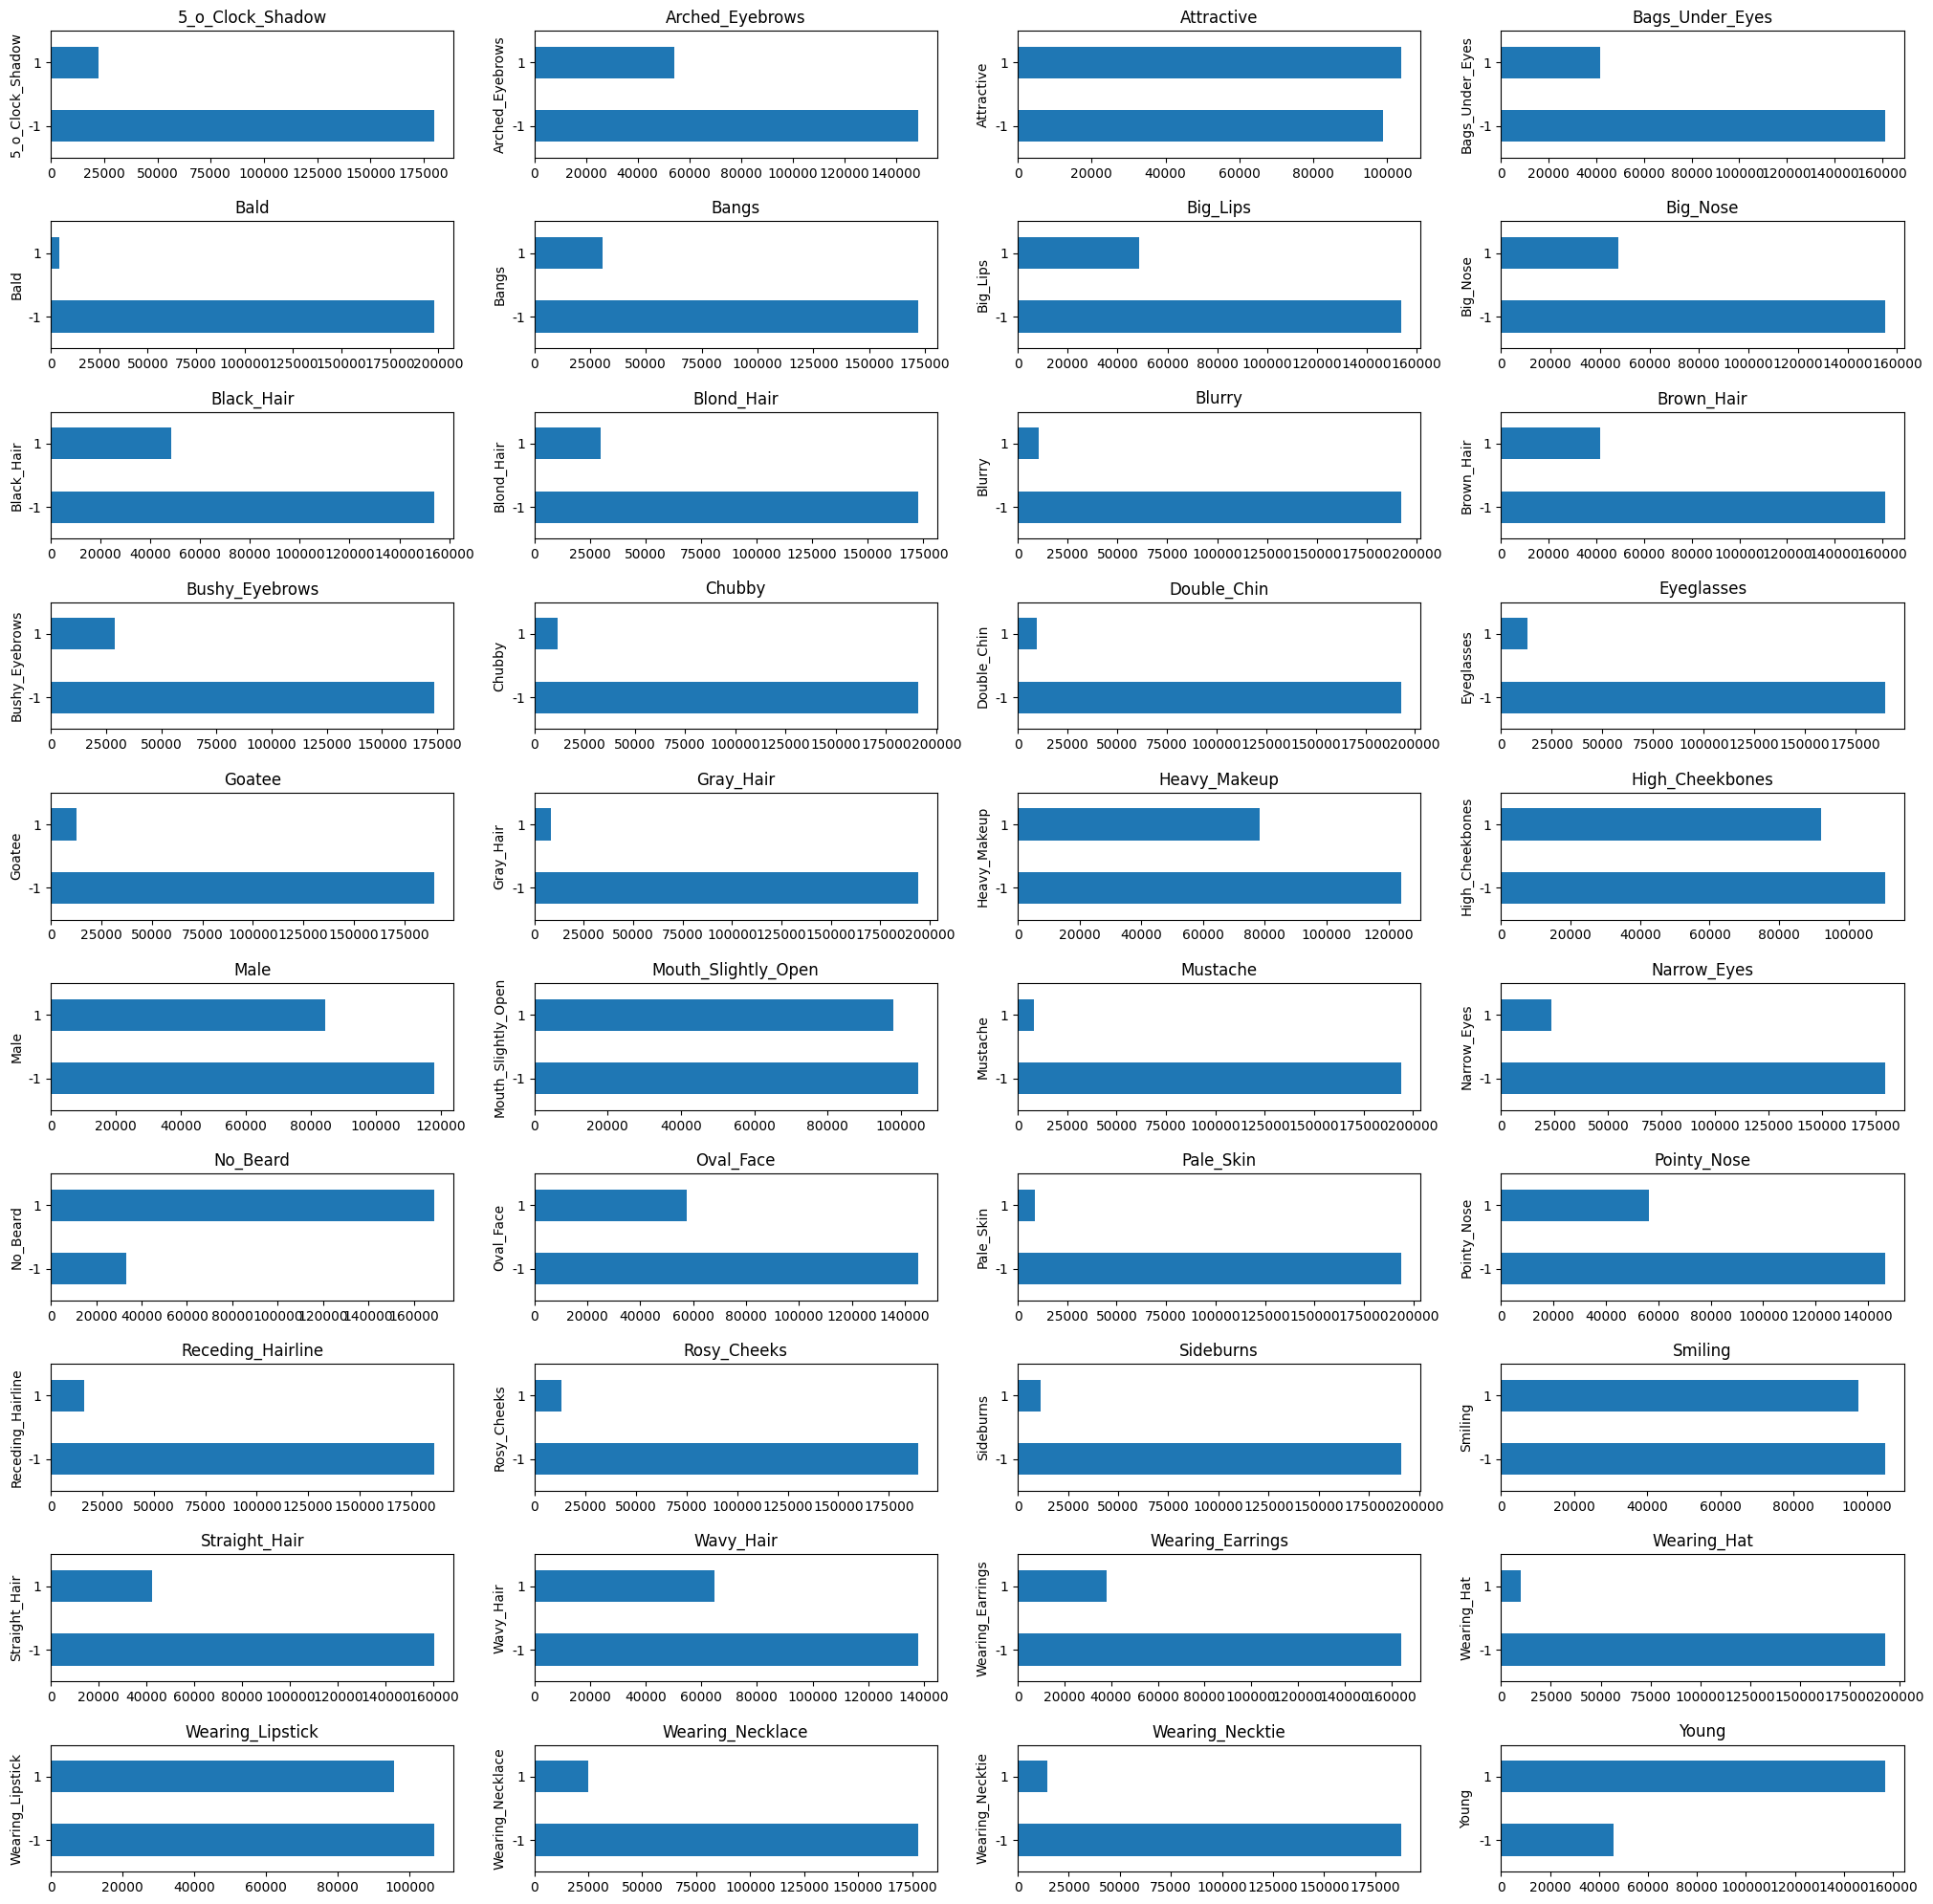

In [11]:
fig, axes = plt.subplots(10,4, figsize=(25,25))

axes = axes.flatten()

for i, column in enumerate(attributes):
    value_counts = attributes[column].value_counts().sort_index(ascending=True)
    value_counts.plot(kind="barh", ax=axes[i])
    axes[i].set_title(column, fontsize=12)
    
plt.subplots_adjust(hspace=0.5)
plt.show()

By looking at the distributions of the 40 binary attributes in CelebA, we can see a wide range of situations. Some variables, such as "Smiling," "Attractive," and "Mouth Slightly Open" are relatively evenly represented across false or true assignments. Other variables are drastically unevenly distributed, such as "Bald," "Wearing Hat," and "Gray Hair," and this can be difficult when training a model. There are very few people in the CelebA dataset that have grey hair or are bald, so it could be difficult for the model to learn what grey hair looks like since it is not exposed to it often. Traits that are underrepresented in this dataset are good candidates for target variables as well, since it will be difficult for a neural network to understand features it is rarely exposed to.

### Dimensionality Reduction - PaCMAP

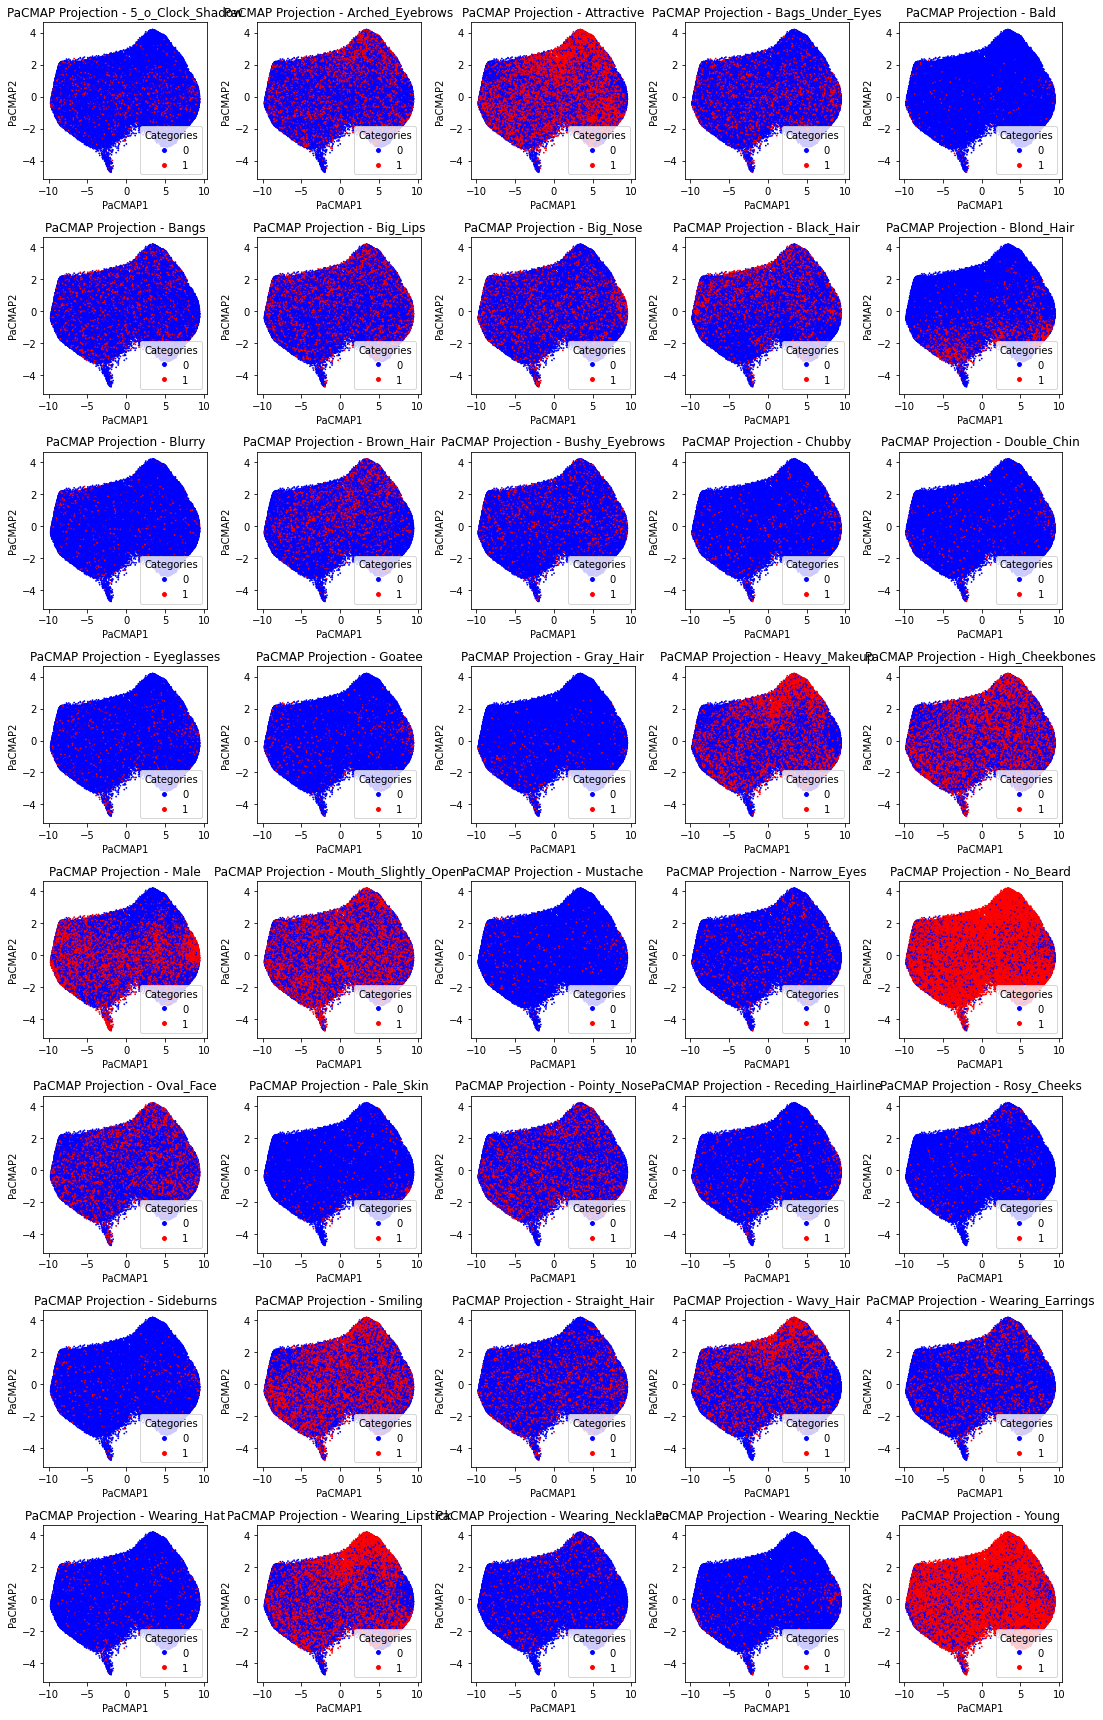

In [3]:
df = pd.read_csv('/Users/leanne/Downloads/celebA_pacmap.csv')

att_names = [
    "5_o_Clock_Shadow",
    "Arched_Eyebrows",
    "Attractive",
    "Bags_Under_Eyes",
    "Bald",
    "Bangs",
    "Big_Lips",
    "Big_Nose",
    "Black_Hair",
    "Blond_Hair",
    "Blurry",
    "Brown_Hair",
    "Bushy_Eyebrows",
    "Chubby",
    "Double_Chin",
    "Eyeglasses",
    "Goatee",
    "Gray_Hair",
    "Heavy_Makeup",
    "High_Cheekbones",
    "Male",
    "Mouth_Slightly_Open",
    "Mustache",
    "Narrow_Eyes",
    "No_Beard",
    "Oval_Face",
    "Pale_Skin",
    "Pointy_Nose",
    "Receding_Hairline",
    "Rosy_Cheeks",
    "Sideburns",
    "Smiling",
    "Straight_Hair",
    "Wavy_Hair",
    "Wearing_Earrings",
    "Wearing_Hat",
    "Wearing_Lipstick",
    "Wearing_Necklace",
    "Wearing_Necktie",
    "Young"
]

# Ensure df exists
if "df" not in locals():
    raise ValueError("df is not defined. Ensure you have loaded the dataset correctly before plotting.")

num_cols = 5  # Number of columns in the grid
num_rows = (len(att_names) + num_cols - 1) // num_cols  # Compute necessary rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))
axes = axes.flatten()

for i, att in enumerate(att_names):
    ax = axes[i]

    # Ensure the attribute exists in df before plotting
    if att in df.columns:
        valid_mask = df[att].isin([0, 1])  # Keep only -1 and 1 values
        colors = df[att][valid_mask].map({0: "blue", 1: "red"}).to_numpy()

        p1 = ax.scatter(df["pacmap_x"][valid_mask], df["pacmap_y"][valid_mask], c=colors, s=0.6)


        # Create a manual legend
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', label='0', markersize=6, markerfacecolor='blue'),
            Line2D([0], [0], marker='o', color='w', label='1', markersize=6, markerfacecolor='red')
        ]
        ax.legend(handles=legend_elements, title="Categories")

    else:
        ax.text(0.5, 0.5, f"Missing: {att}", fontsize=12, ha='center')

    ax.set_xlabel("PaCMAP1")
    ax.set_ylabel("PaCMAP2")
    ax.set_title(f"PaCMAP Projection - {att}")

plt.tight_layout()
plt.show()

After reducing the dimensionality of our dataset via PaCMAP and plotting each of the 40 CelebA attributes, we can see that most of the traits in the dataset are not easily separable using this dimension reduction technique. If a trait is separable, we would expect to see clear clusters distinguishing the trait. For example, when looking at the plot for "Young" there would be a distinct cluster of images labelled 0 (not young), and images labelled 1 (young). However, for virtually all of our variables this is not the case using PaCMAP. While this is a different technique and can't definitively tell us whether a neural network will be able to accurately classify image attributes, it can give us a sense for what variables may be a challenge to correctly identify. In theory, attributes that aren't separable (which is pretty much all of our variables) may be harder for the neural network to classify and thus better for us to use in our project. This visualization does not point to any obvious variables, but rather tells us that most of the traits in this dataset are not easily distinguishable from one another via PaCMAP.

## Biased MNIST Data Exploration

### 0.1 Correlation Dataset

In [40]:
biased_mnist_01 = pd.read_json("biased_mnist/full_0.1/trainval.json") # directory and file name may be different when running

In [41]:
biased_mnist_01 = biased_mnist_01.drop(columns=['digit_color', 'digit_position', 'digit_scale_ix', 'index', 'letter_color', "letter_ix", "texture_color", "texture_color_ix", 'texture_ix'])

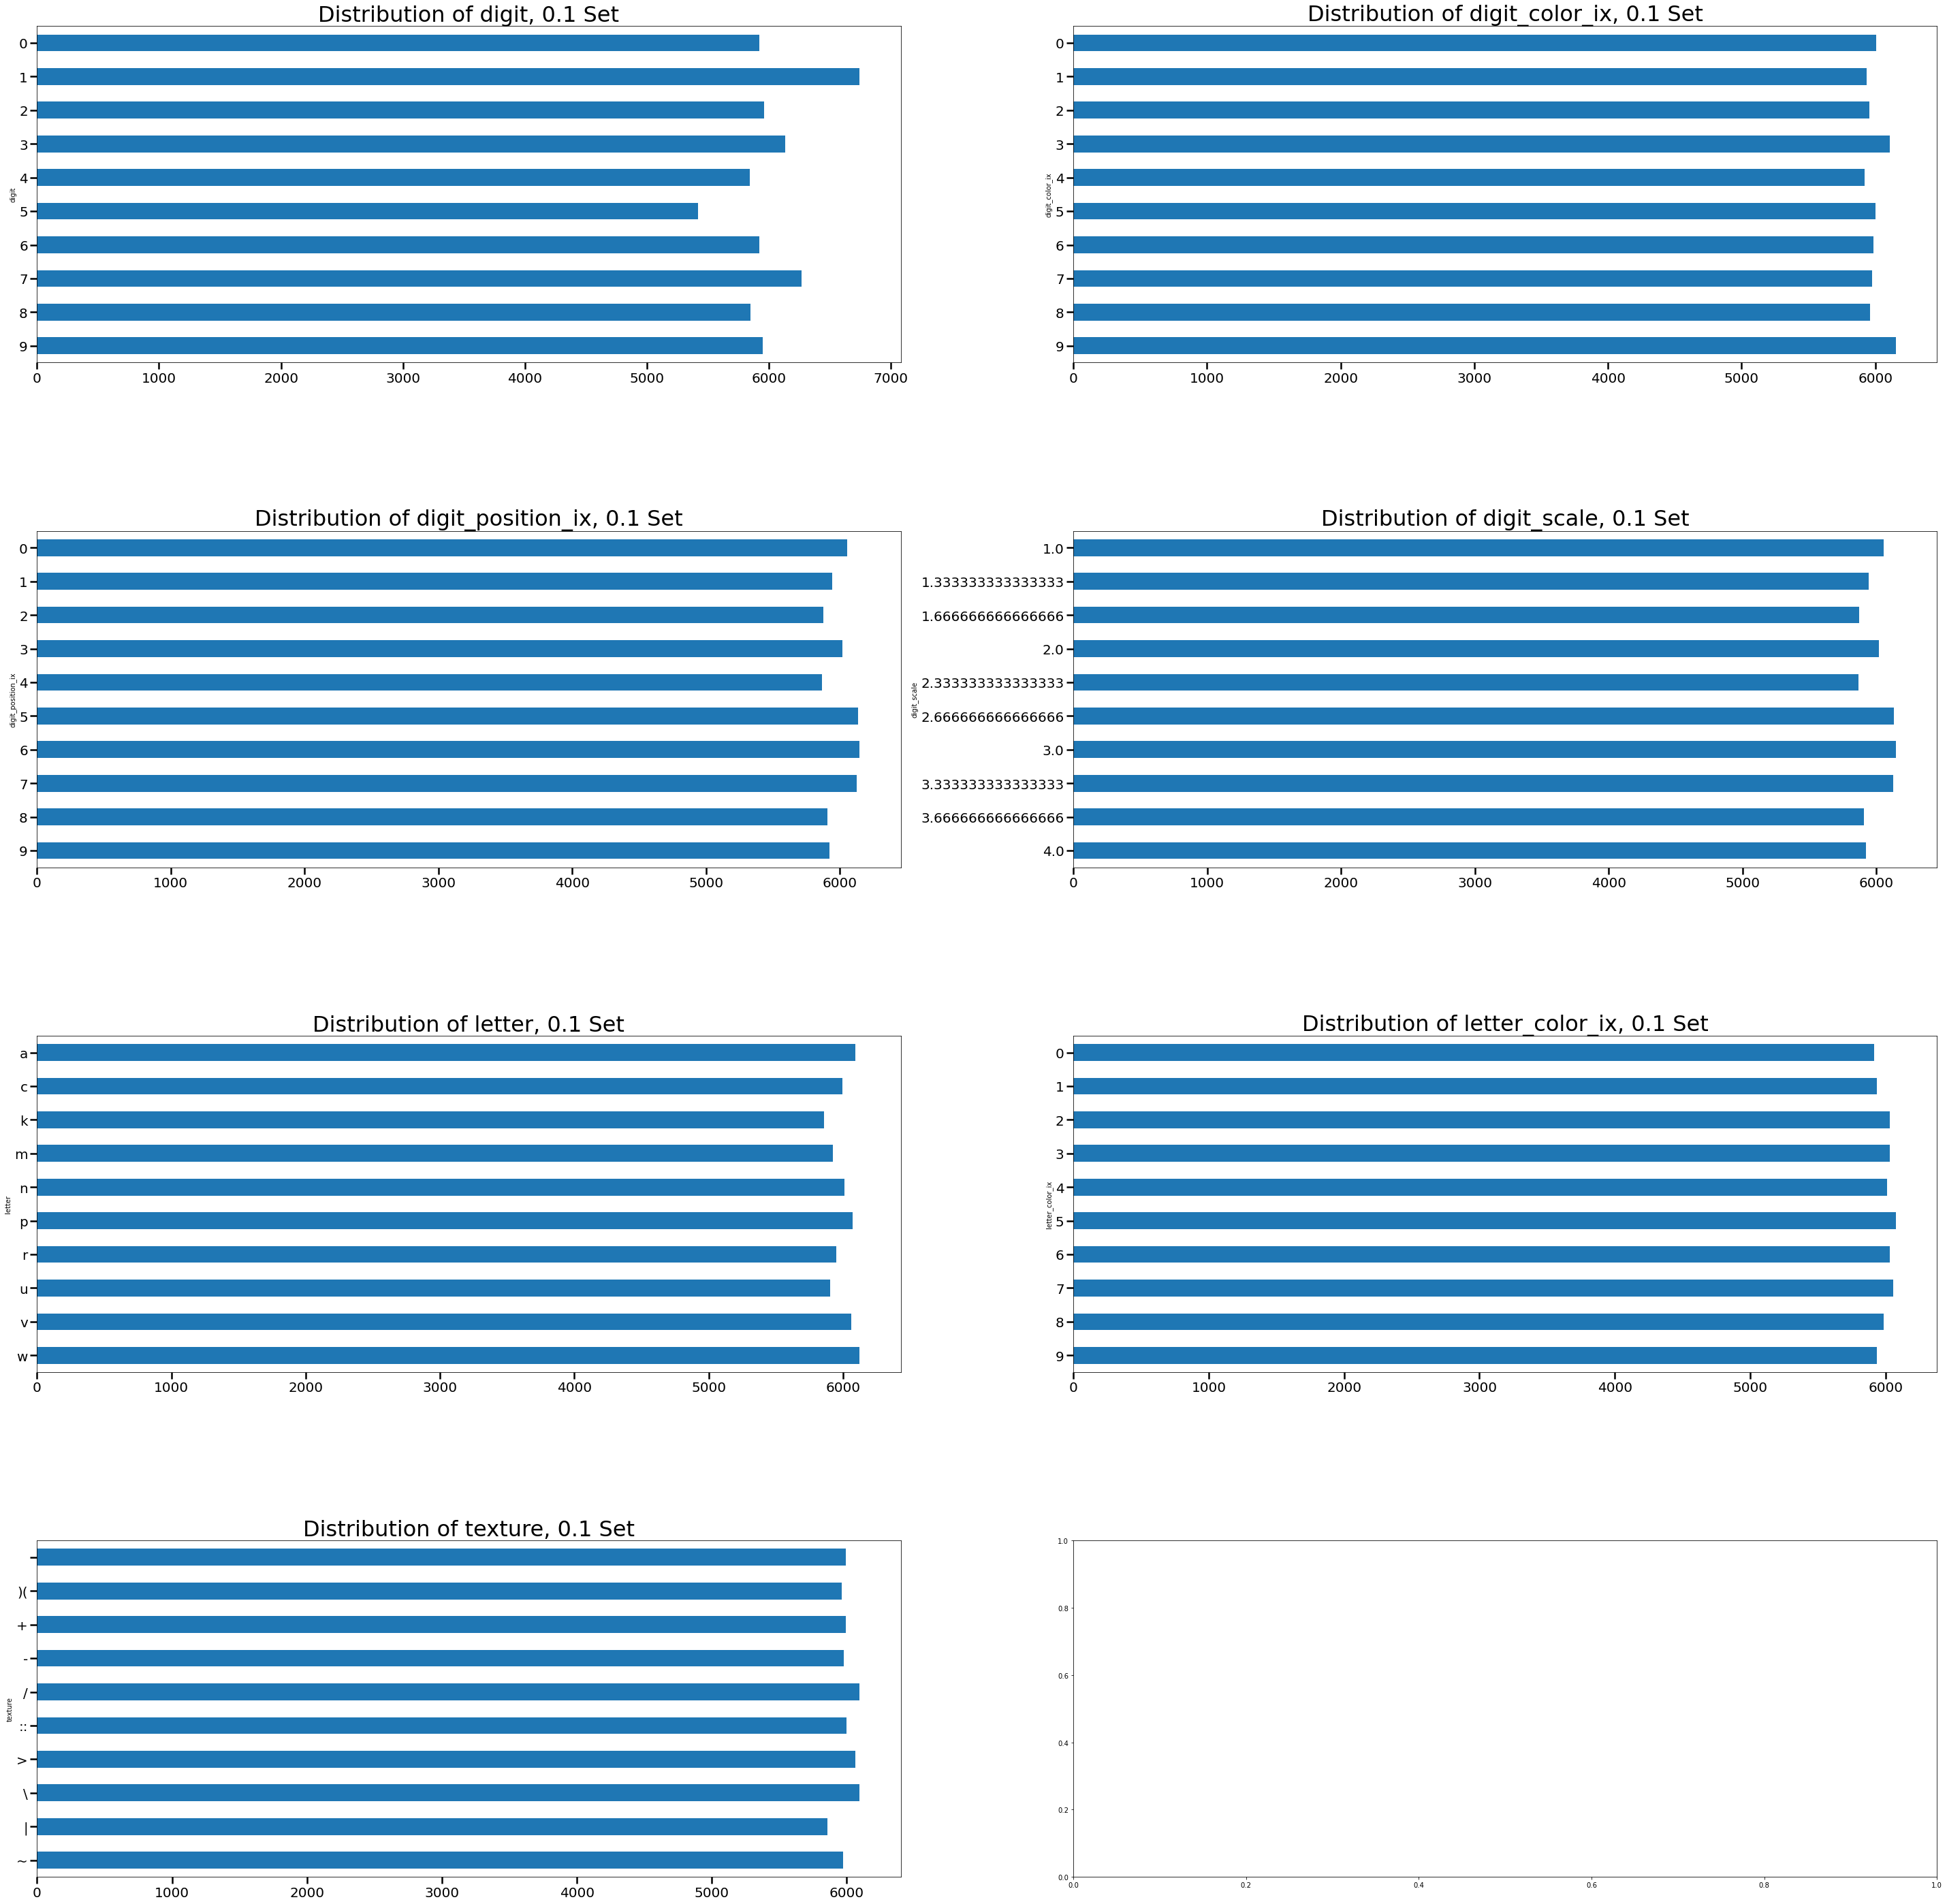

In [42]:
fig, axes = plt.subplots(4, 2, figsize=(50,50))

axes = axes.flatten()

for i, column in enumerate(biased_mnist_01):
    biased_mnist_01[column].value_counts().sort_index(ascending=False).plot(kind="barh", ax=axes[i])
    axes[i].set_title(f"Distribution of {column}, 0.1 Set", fontsize=32)
    axes[i].tick_params(axis='both', which='major', labelsize=20, width=2.5, length=10)
    
plt.subplots_adjust(hspace=0.5)
plt.show()

In the 0.1 correlation set, each variable is approximately evenly distributed across categories. In the sections below, we will use stacked bar charts to identify what these distributions look like when broken down by target variable (digit).

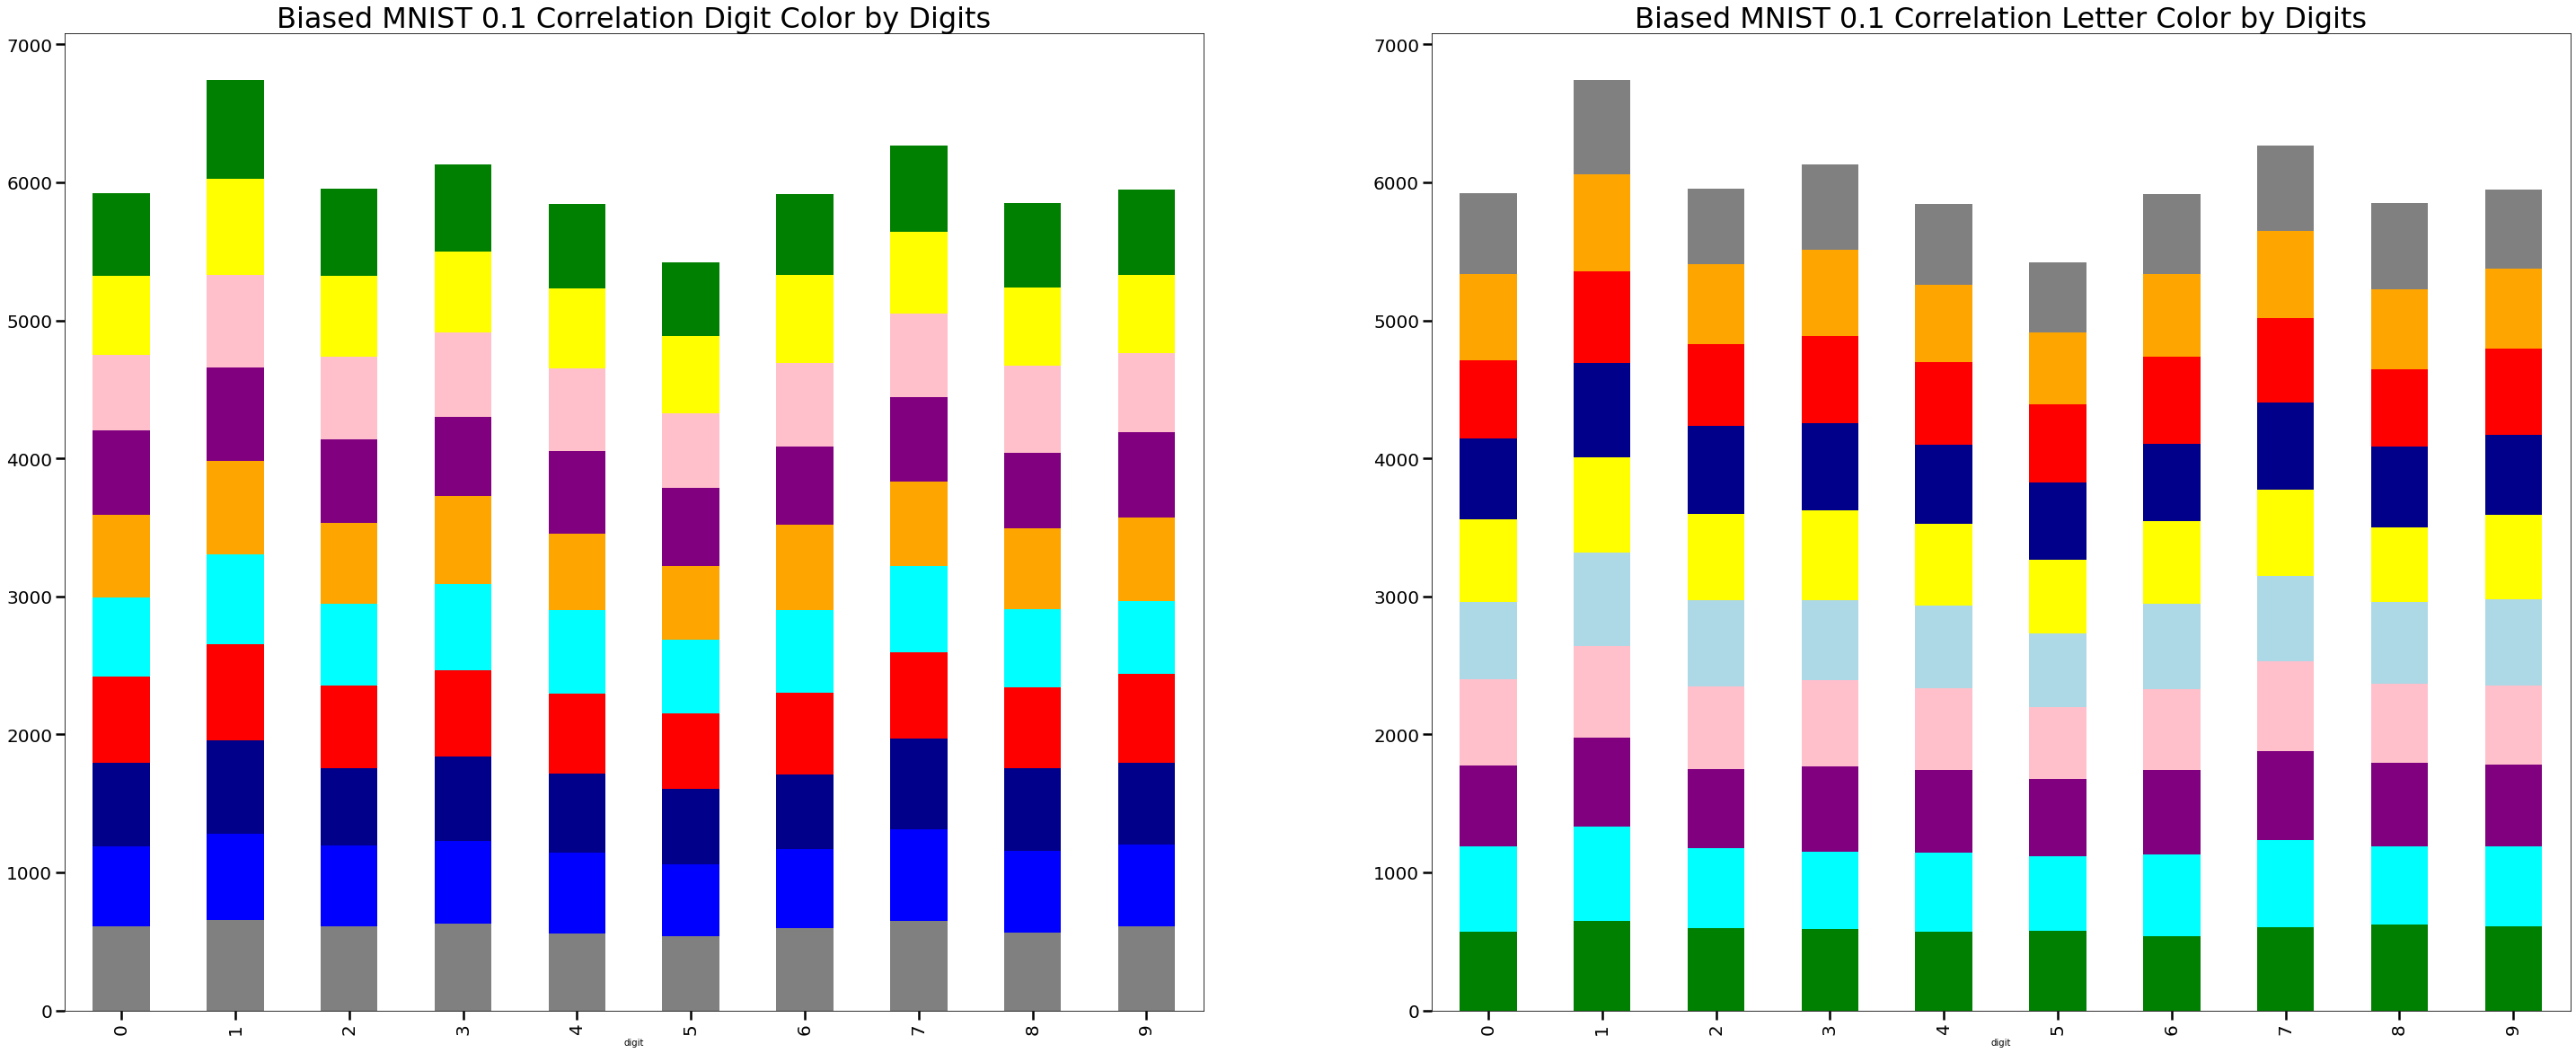

In [43]:
digit_color_dict = {9: "green", 5: "orange", 2: "darkblue", 1: "blue", 3: "red", 7: "pink", 8: "yellow", 0: "grey", 4: "cyan", 6: "purple"}
letter_color_dict = {9: "grey", 5: "yellow", 2: "purple", 1: "cyan", 3: "pink", 7: "red", 8: "orange", 0: "green", 4: "lightblue", 6: "darkblue"}

color_list = [digit_color_dict[i] for i in sorted(biased_mnist_01["digit_color_ix"].unique())]
letter_color_list = [letter_color_dict[i] for i in sorted(biased_mnist_01["letter_color_ix"].unique())]

fig, axes = plt.subplots(1, 2, figsize=(50,20))

axes = axes.flatten()

biased_mnist_01.groupby(by=['digit','digit_color_ix']).size().rename('count').unstack().plot(
    kind='bar', stacked=True, color=color_list, legend = None, ax=axes[0]
)
axes[0].set_title("Biased MNIST 0.1 Correlation Digit Color by Digits", fontsize=32)
axes[0].tick_params(axis='both', which='major', labelsize=20, width=2.5, length=10)

biased_mnist_01.groupby(by=['digit','letter_color_ix']).size().rename('count').unstack().plot(
    kind='bar', stacked=True, color=letter_color_list, legend = None, ax=axes[1]
)
axes[1].set_title("Biased MNIST 0.1 Correlation Letter Color by Digits", fontsize=32)
axes[1].tick_params(axis='both', which='major', labelsize=20, width=2.5, length=10)

plt.show()

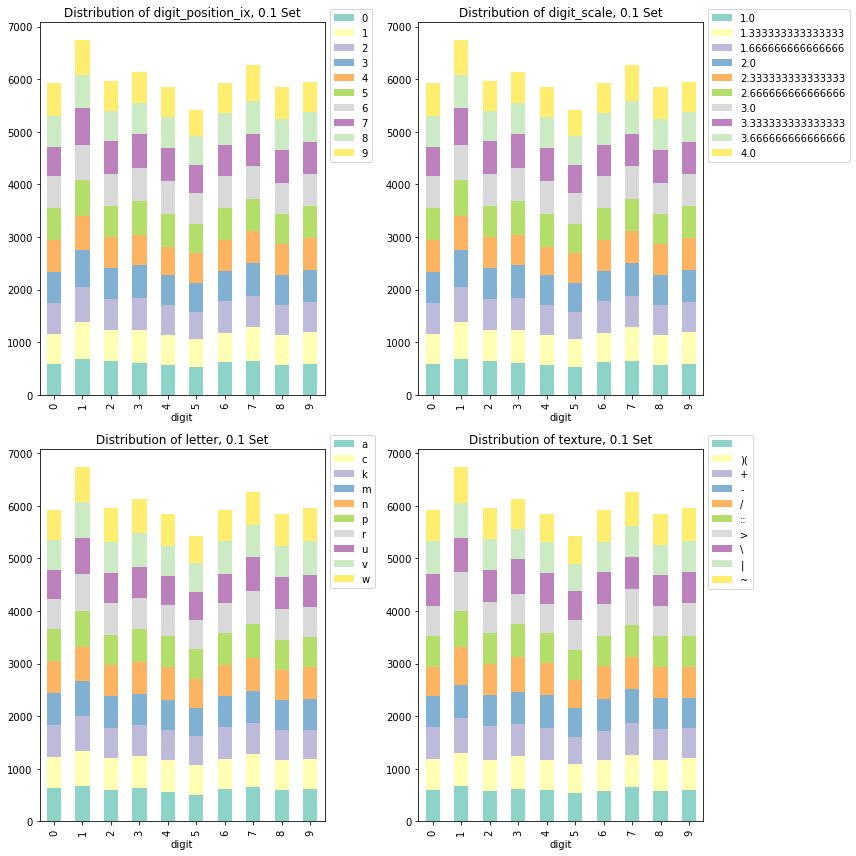

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

columns = ["digit_position_ix", "digit_scale", "letter", "texture"]

for i, column in enumerate(columns):
    ax = biased_mnist_01.groupby(by=['digit', column]).size().rename('count').unstack().plot(
        kind='bar', stacked=True, ax=axes[i], cmap="Set3"
    )
    ax.legend(bbox_to_anchor=(1, 1.05))
    ax.set_title(f"Distribution of {column}, 0.1 Set", fontsize=12)

plt.tight_layout()
plt.show()

Each digit has relatively equal color distribution for the digit itself and the letter in the image for the 0.1 correlation set, which is not surprising. Because the colors are so evenly represented, it is easier for the neural network to learn them because it is exposed to each color in similar frequencies. The same held for other image properties. Texture, letter, digit position, and digit scale are all approximately evenly distributed across digits. This will make it easier for the neural network to make accurate predictions because it has been exposed to different features at similar rates. This is ideal for training an less biased model, however that is not the goal of our project. We are seeking to create an intentionally biased model to fix, and using a balanced dataset will mitigate bias that could come from class imbalance. Thus, the 0.1 correlation MNIST dataset is likely not a good choice to build our model with.

### 0.5 Correlation Dataset

In [35]:
biased_mnist_05 = pd.read_json("biased_mnist/full_0.5/trainval.json") # directory and file name may be different when running

In [36]:
biased_mnist_05 = biased_mnist_05.drop(columns=['digit_color', 'digit_position', 'digit_scale_ix', 'index', 'letter_color', "letter_ix", "texture_color", "texture_color_ix", 'texture_ix'])

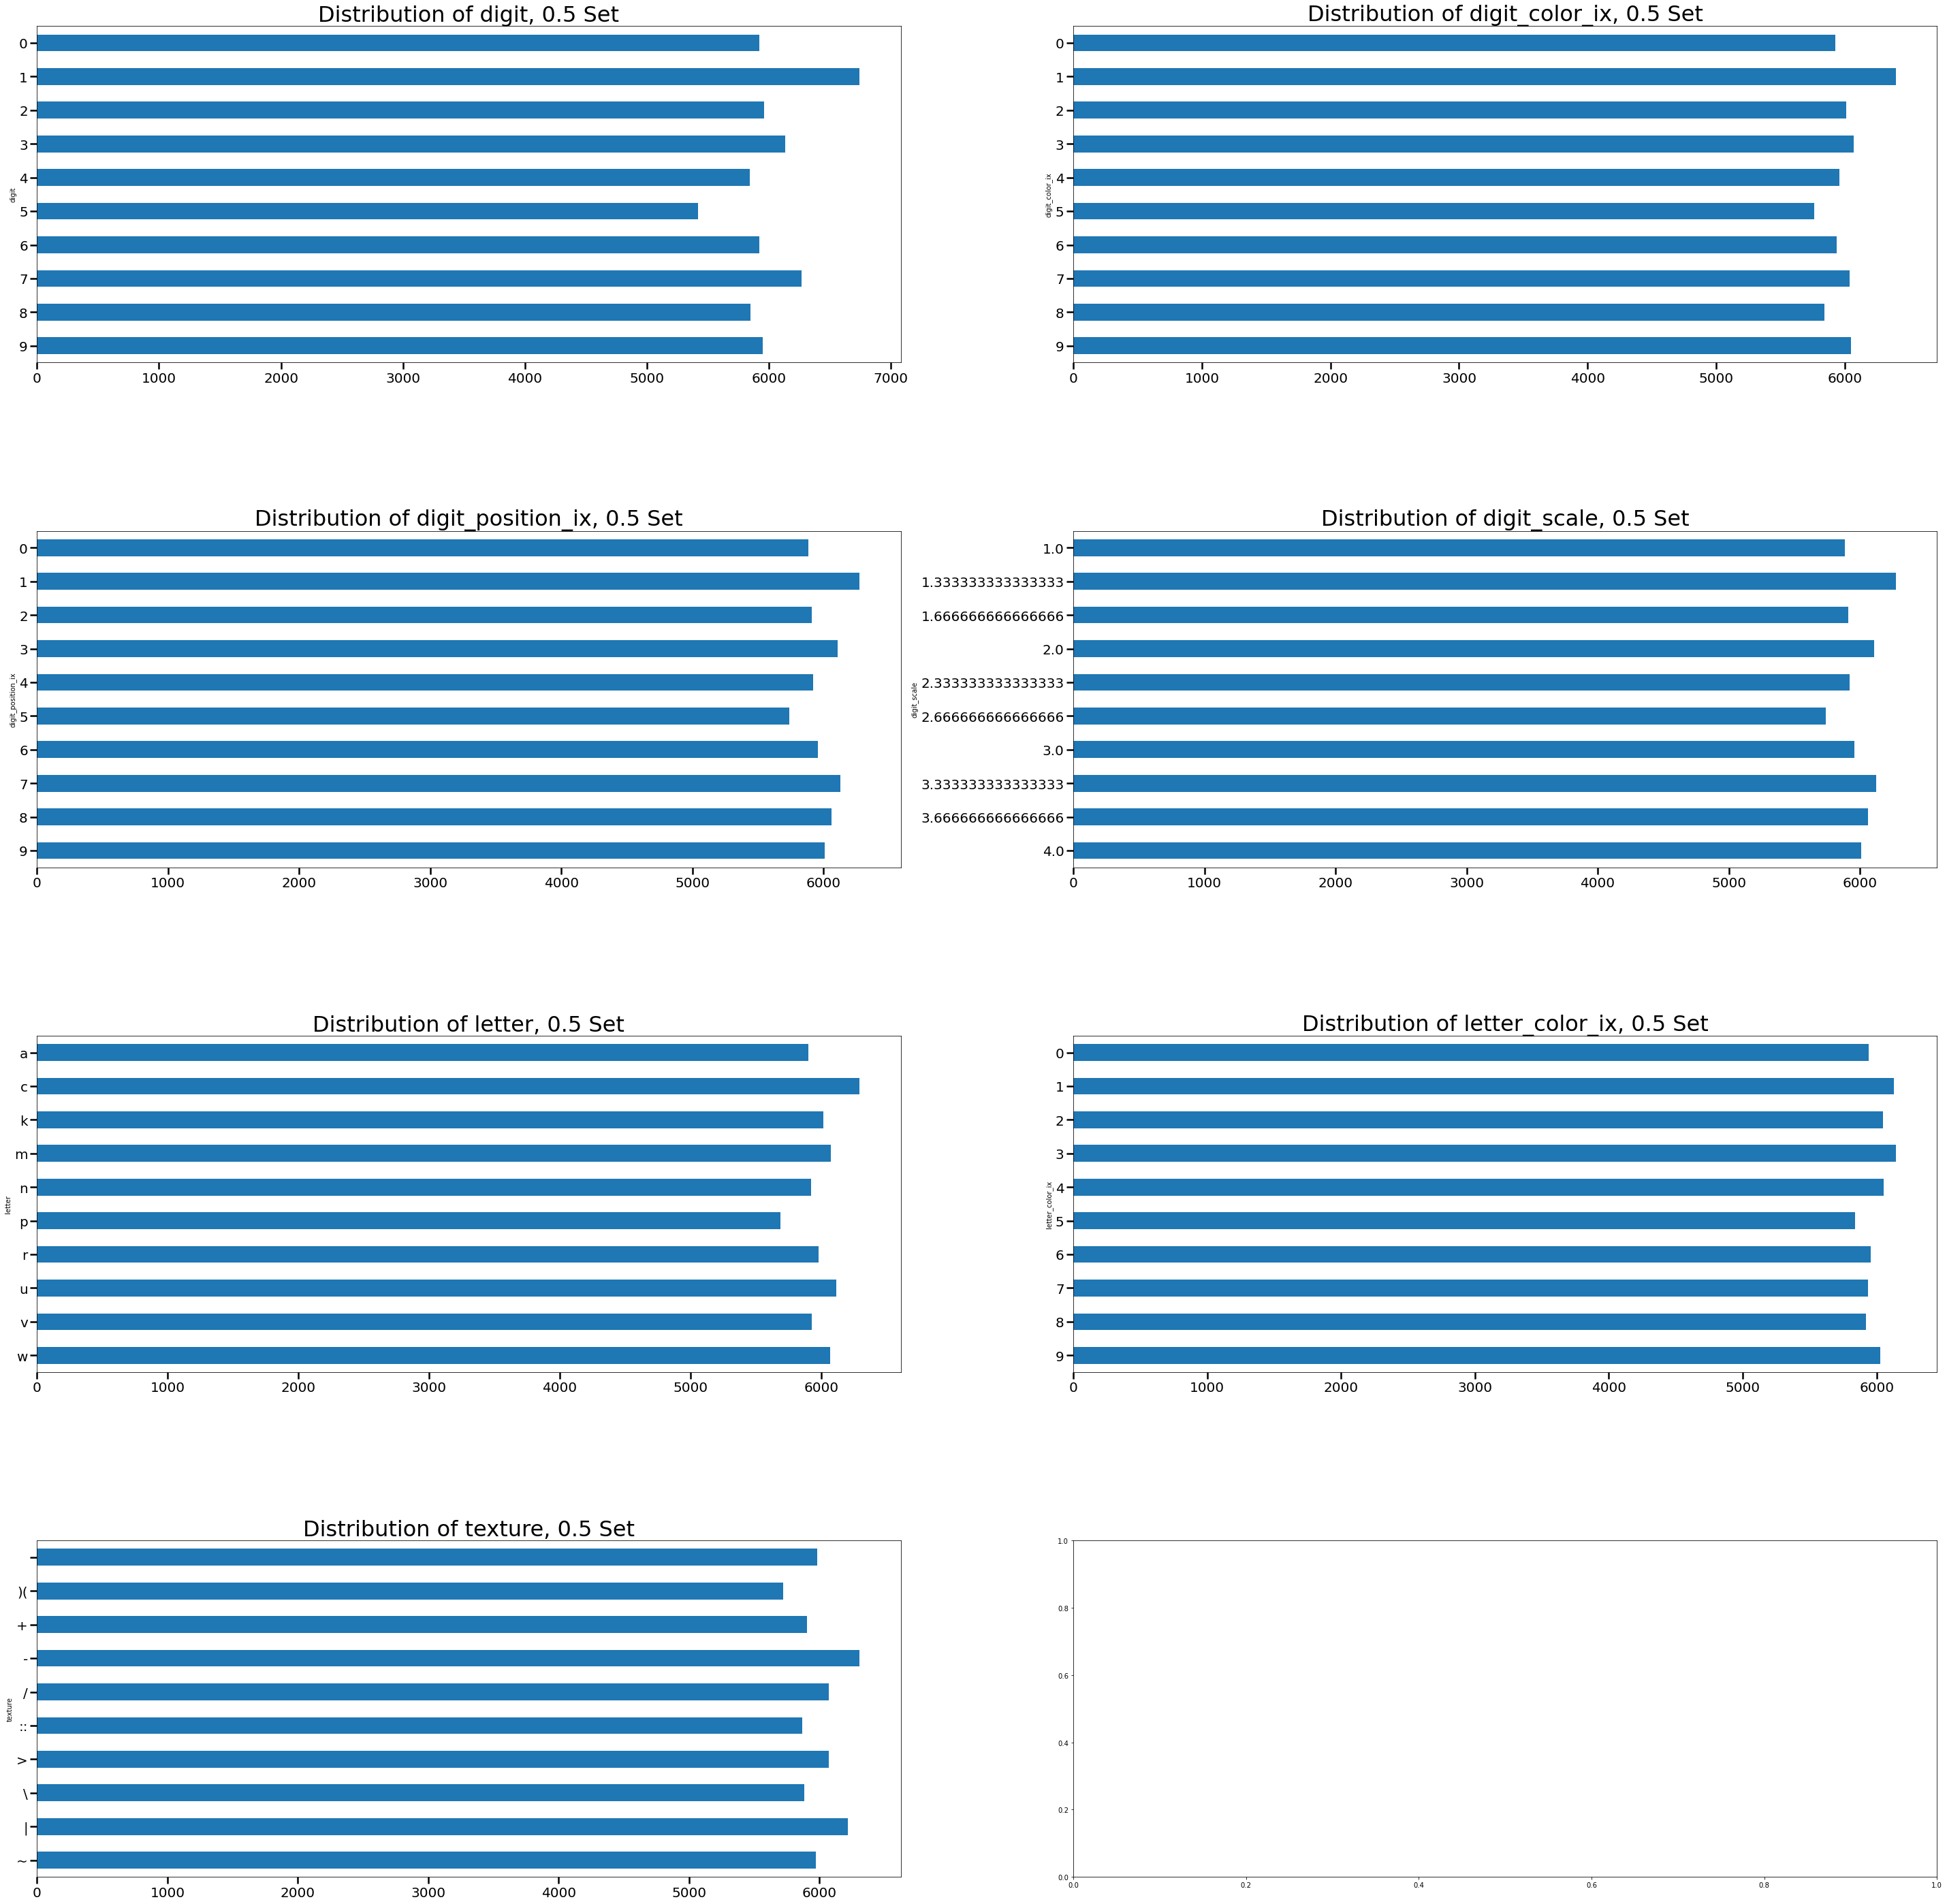

In [38]:
fig, axes = plt.subplots(4, 2, figsize=(50,50))

axes = axes.flatten()

for i, column in enumerate(biased_mnist_05):
    biased_mnist_05[column].value_counts().sort_index(ascending=False).plot(kind="barh", ax=axes[i])
    axes[i].set_title(f"Distribution of {column}, 0.5 Set", fontsize=32)
    axes[i].tick_params(axis='both', which='major', labelsize=20, width=2.5, length=10)
    
plt.subplots_adjust(hspace=0.5)
plt.show()

In the 0.5 correlation set, each variable is still approximately evenly distributed across categories, although slightly less evenly than in the 0.1 correlation dataset. We will use stacked bar charts to identify what these distributions look like when broken down by target variable (digit) below. We are anticipating that distributions of variables across digits will become more uneven as the correlation of the dataset increases.

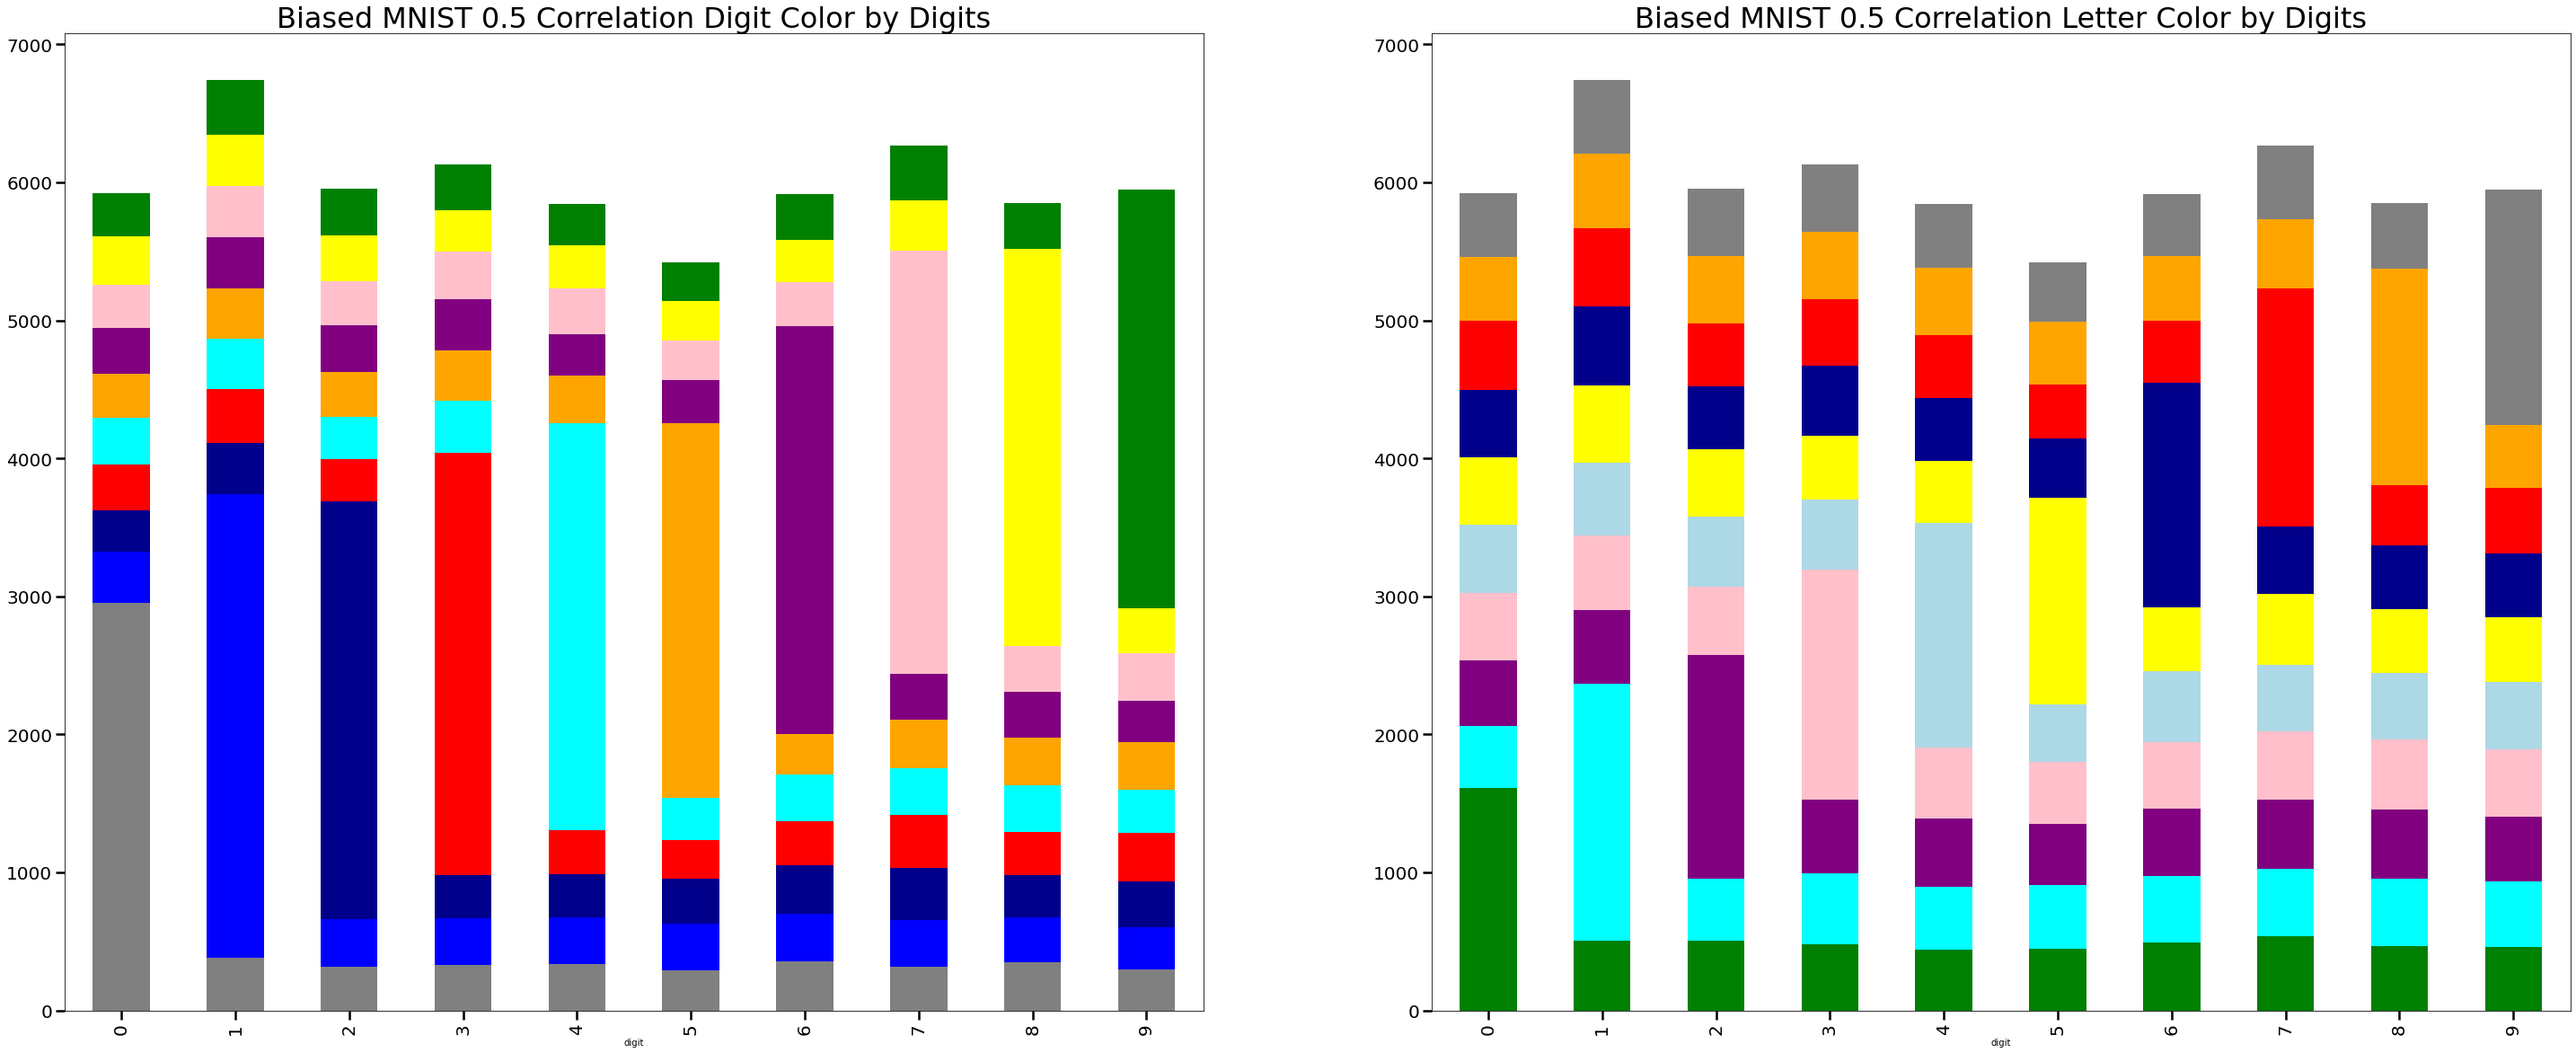

In [37]:
digit_color_dict = {9: "green", 5: "orange", 2: "darkblue", 1: "blue", 3: "red", 7: "pink", 8: "yellow", 0: "grey", 4: "cyan", 6: "purple"}
letter_color_dict = {9: "grey", 5: "yellow", 2: "purple", 1: "cyan", 3: "pink", 7: "red", 8: "orange", 0: "green", 4: "lightblue", 6: "darkblue"}

color_list = [digit_color_dict[i] for i in sorted(biased_mnist_05["digit_color_ix"].unique())]
letter_color_list = [letter_color_dict[i] for i in sorted(biased_mnist_05["letter_color_ix"].unique())]

fig, axes = plt.subplots(1, 2, figsize=(50,20))
axes = axes.flatten()

biased_mnist_05.groupby(by=['digit','digit_color_ix']).size().rename('count').unstack().plot(
    kind='bar', stacked=True, color=color_list, legend = None, ax=axes[0]
)
axes[0].set_title("Biased MNIST 0.5 Correlation Digit Color by Digits", fontsize=32)
axes[0].tick_params(axis='both', which='major', labelsize=20, width=2.5, length=10)

biased_mnist_05.groupby(by=['digit','letter_color_ix']).size().rename('count').unstack().plot(
    kind='bar', stacked=True, color=letter_color_list, legend = None, ax=axes[1]
)
axes[1].set_title("Biased MNIST 0.5 Correlation Letter Color by Digits", fontsize=32)
axes[1].tick_params(axis='both', which='major', labelsize=20, width=2.5, length=10)

plt.show()

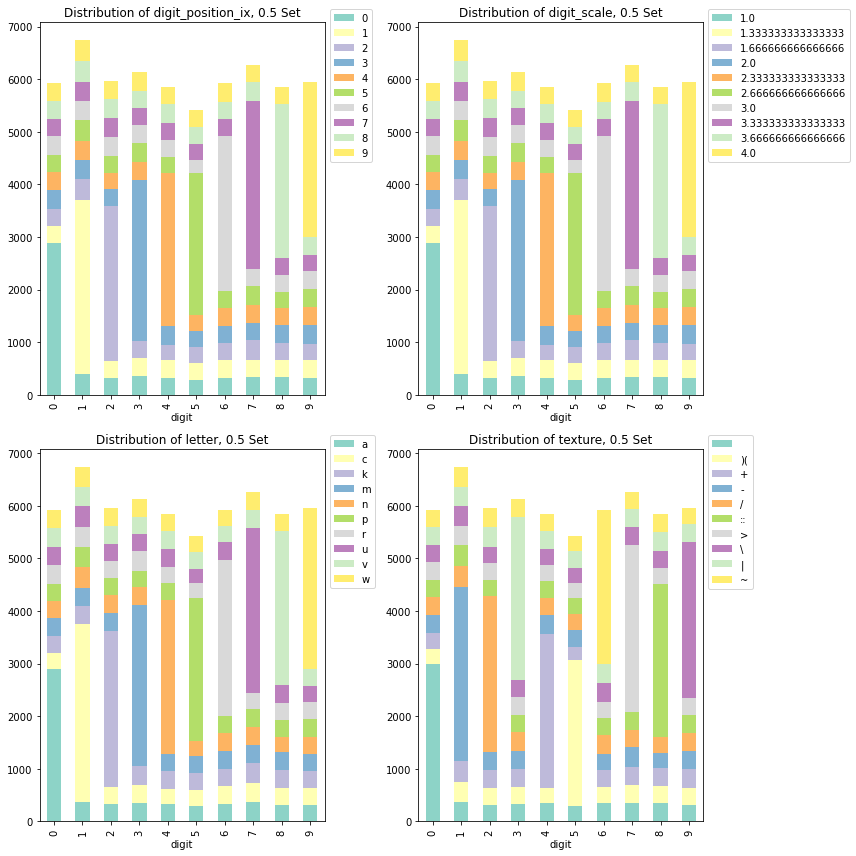

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

columns = ["digit_position_ix", "digit_scale", "letter", "texture"]

for i, column in enumerate(columns):
    ax = biased_mnist_05.groupby(by=['digit', column]).size().rename('count').unstack().plot(
        kind='bar', stacked=True, ax=axes[i], cmap="Set3"
    )
    ax.legend(bbox_to_anchor=(1, 1.05))
    ax.set_title(f"Distribution of {column}, 0.5 Set", fontsize=12)

plt.tight_layout()
plt.show()

In the 0.5 correlation dataset, we can see that distributions of variables are becoming more uneven across digits. For example, the majority of images that have a 1 as the digit have an "a" as the letter, no texture, an image scale of 1.0, and the digit is at 0. The image color is most often grey, and the letter is green. Other variable categories are represented for each digit, although much less frequently (approximately 300 images per class for the non-dominant class, while the dominant class is present in about 2800 images). This will likely introduce some bias in our model. Since the model has most frequently been exposed to the dominant class, it will have trouble learning about the non-dominant classes with the same accuracy. Similar to human learning, neural networks have difficulty understanding attributes that they are not frequently exposed to, which makes this dataset a better candidate for use in our project than the 0.1 correlation dataset.

### 0.99 Correlation Dataset

In [21]:
biased_mnist_09 = pd.read_json("biased_mnist/full_0.99/trainval.json") # directory and file name may be different when running

In [22]:
biased_mnist_09 = biased_mnist_09.drop(columns=['digit_color', 'digit_position', 'digit_scale_ix', 'index', 'letter_color', "letter_ix", "texture_color", "texture_color_ix", 'texture_ix'])

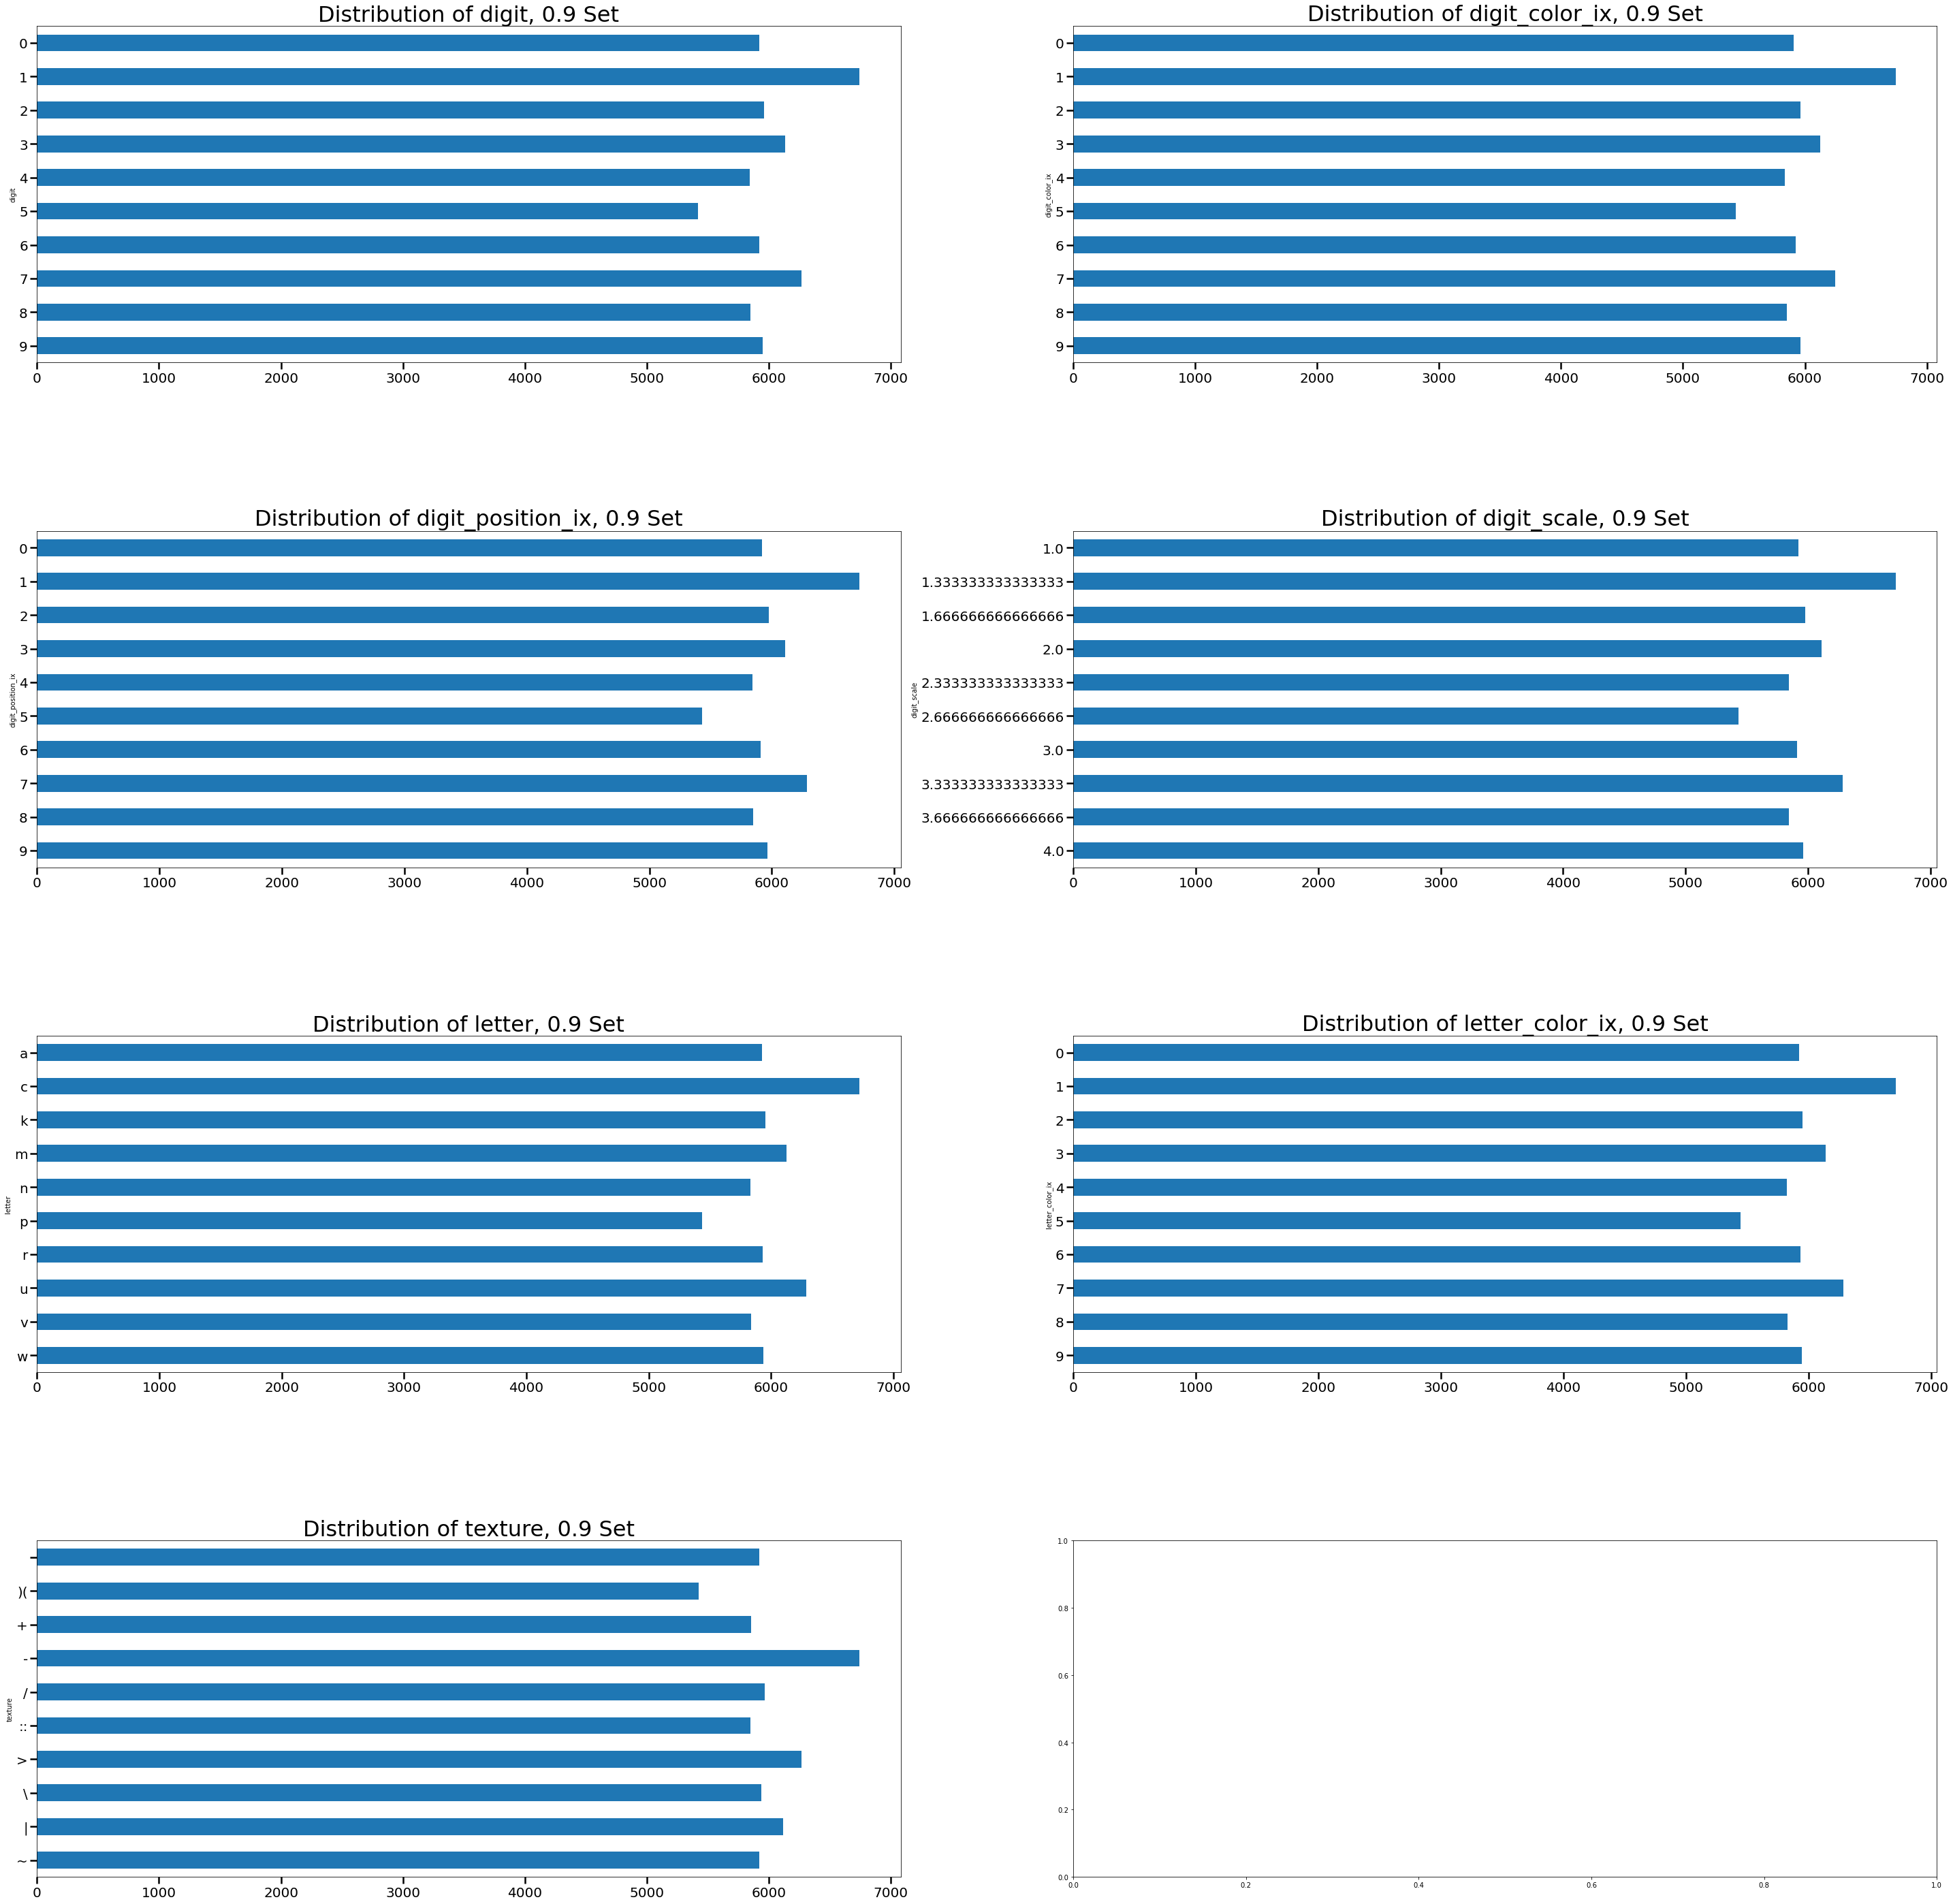

In [33]:
fig, axes = plt.subplots(4, 2, figsize=(50,50))

axes = axes.flatten()

for i, column in enumerate(biased_mnist_09):
    biased_mnist_09[column].value_counts().sort_index(ascending=False).plot(kind="barh", ax=axes[i])
    axes[i].set_title(f"Distribution of {column}, 0.9 Set", fontsize=32)
    axes[i].tick_params(axis='both', which='major', labelsize=20, width=2.5, length=10)
    
plt.subplots_adjust(hspace=0.5)
plt.show()

For the 0.99 correlation dataset, each class for the variables are decently well-represented, although not as evenly as in the 0.1 correlation dataset that we examined earlier.

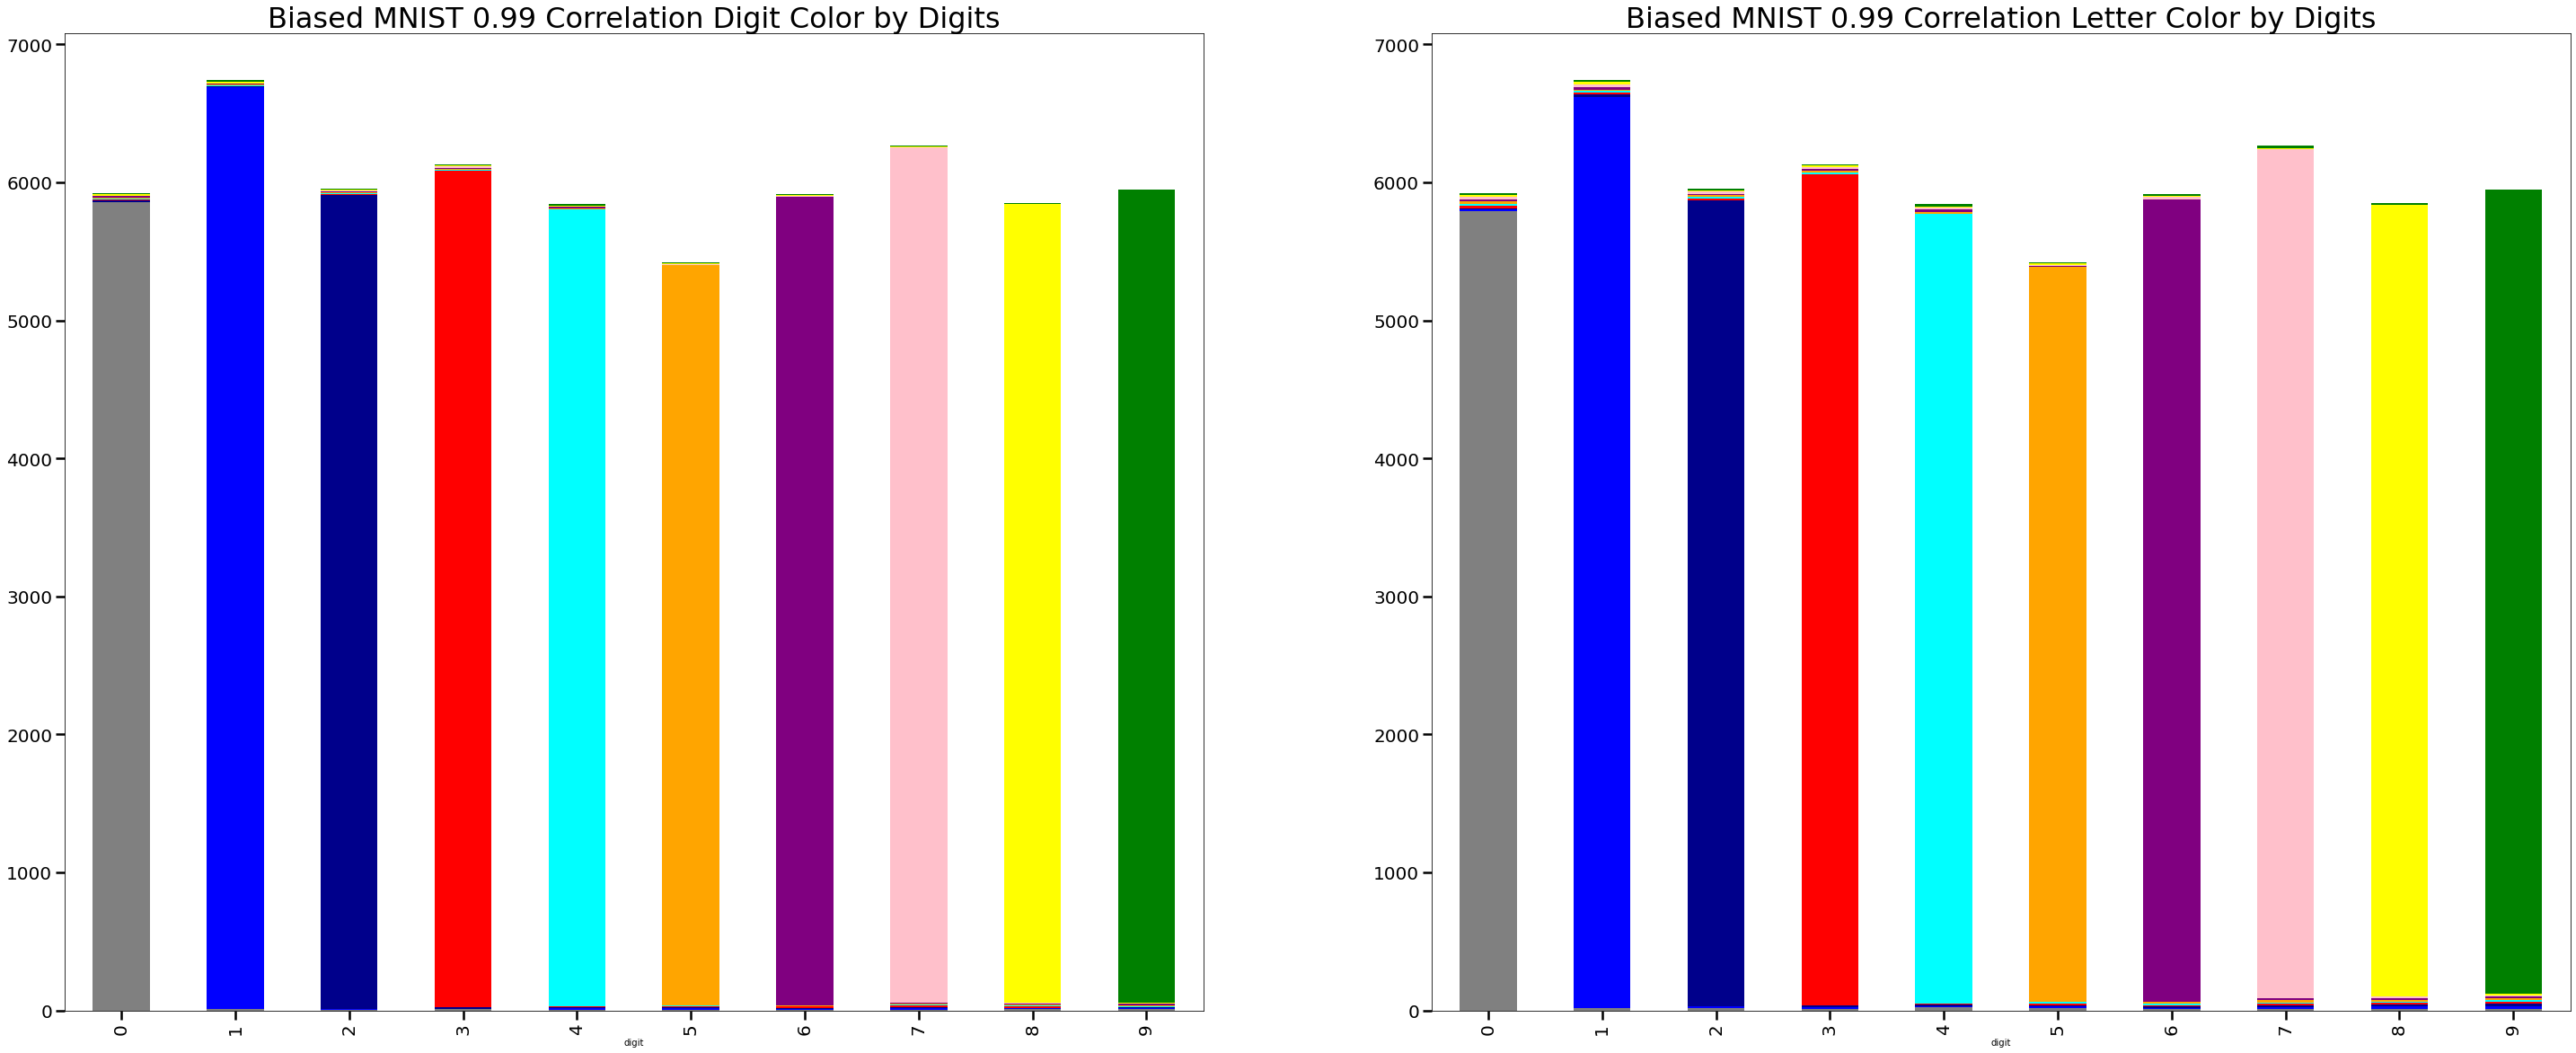

In [44]:
digit_color_dict = {9: "green", 5: "orange", 2: "darkblue", 1: "blue", 3: "red", 7: "pink", 8: "yellow", 0: "grey", 4: "cyan", 6: "purple"}
letter_color_dict = {9: "grey", 5: "yellow", 2: "purple", 1: "cyan", 3: "pink", 7: "red", 8: "orange", 0: "green", 4: "lightblue", 6: "darkblue"}

color_list = [digit_color_dict[i] for i in sorted(biased_mnist_09["digit_color_ix"].unique())]
letter_color_list = [letter_color_dict[i] for i in sorted(biased_mnist_09["letter_color_ix"].unique())]

fig, axes = plt.subplots(1, 2, figsize=(50,20))
axes = axes.flatten()

biased_mnist_09.groupby(by=['digit','digit_color_ix']).size().rename('count').unstack().plot(
    kind='bar', stacked=True, color=color_list, legend = None, ax=axes[0]
)
axes[0].set_title("Biased MNIST 0.99 Correlation Digit Color by Digits", fontsize=32)
axes[0].tick_params(axis='both', which='major', labelsize=20, width=2.5, length=10)

biased_mnist_09.groupby(by=['digit','letter_color_ix']).size().rename('count').unstack().plot(
    kind='bar', stacked=True, color=color_list, legend = None, ax=axes[1]
)
axes[1].set_title("Biased MNIST 0.99 Correlation Letter Color by Digits", fontsize=32)
axes[1].tick_params(axis='both', which='major', labelsize=20, width=2.5, length=10)

plt.show()

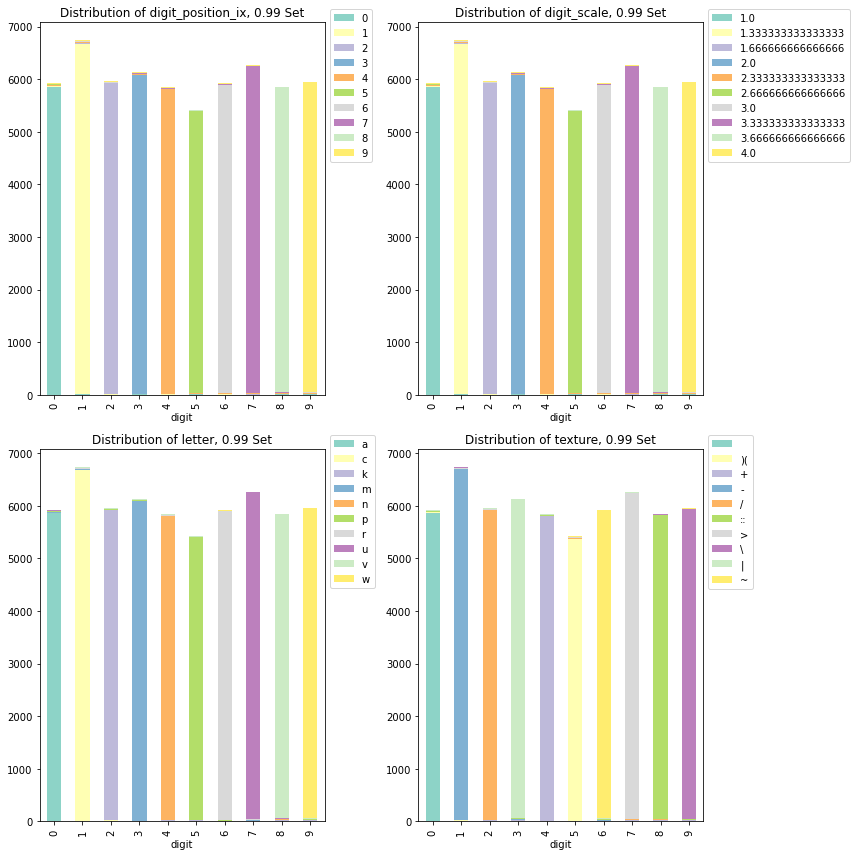

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

columns = ["digit_position_ix", "digit_scale", "letter", "texture"]

for i, column in enumerate(columns):
    ax = biased_mnist_09.groupby(by=['digit', column]).size().rename('count').unstack().plot(
        kind='bar', stacked=True, ax=axes[i], cmap="Set3"
    )
    ax.legend(bbox_to_anchor=(1, 1.05))
    ax.set_title(f"Distribution of {column}, 0.99 Set", fontsize=12)

plt.tight_layout()
plt.show()

In the 0.99 correlation dataset, we can see extremely uneven distributions of variables across digits. Now, the non-domimant classes account for only ~50 images each, while the domimant class appears in the rest of the images (typically between 5,500-6,500 images for each digit that contain the domimant class). This dataset is likely to introduce the most bias from uneven class distributions into our model since there is virtually no exposure to the non-dominant classes for the model to learn from. The extremely small number of non-dominant class images could make mitigation techniques such as resampling difficult though, since the network would be learning the same 50 images over and over. The 0.99 and 0.5 datasets are our best options for use that we have explored.

### Test Dataset

In [45]:
biased_mnist_test = pd.read_json("biased_mnist/full/test.json") # directory and file name may be different when running

In [46]:
biased_mnist_test = biased_mnist_test.drop(columns=['digit_color', 'digit_position', 'digit_scale_ix', 'index', 'letter_color', "letter_ix", "texture_color", "texture_color_ix", 'texture_ix'])

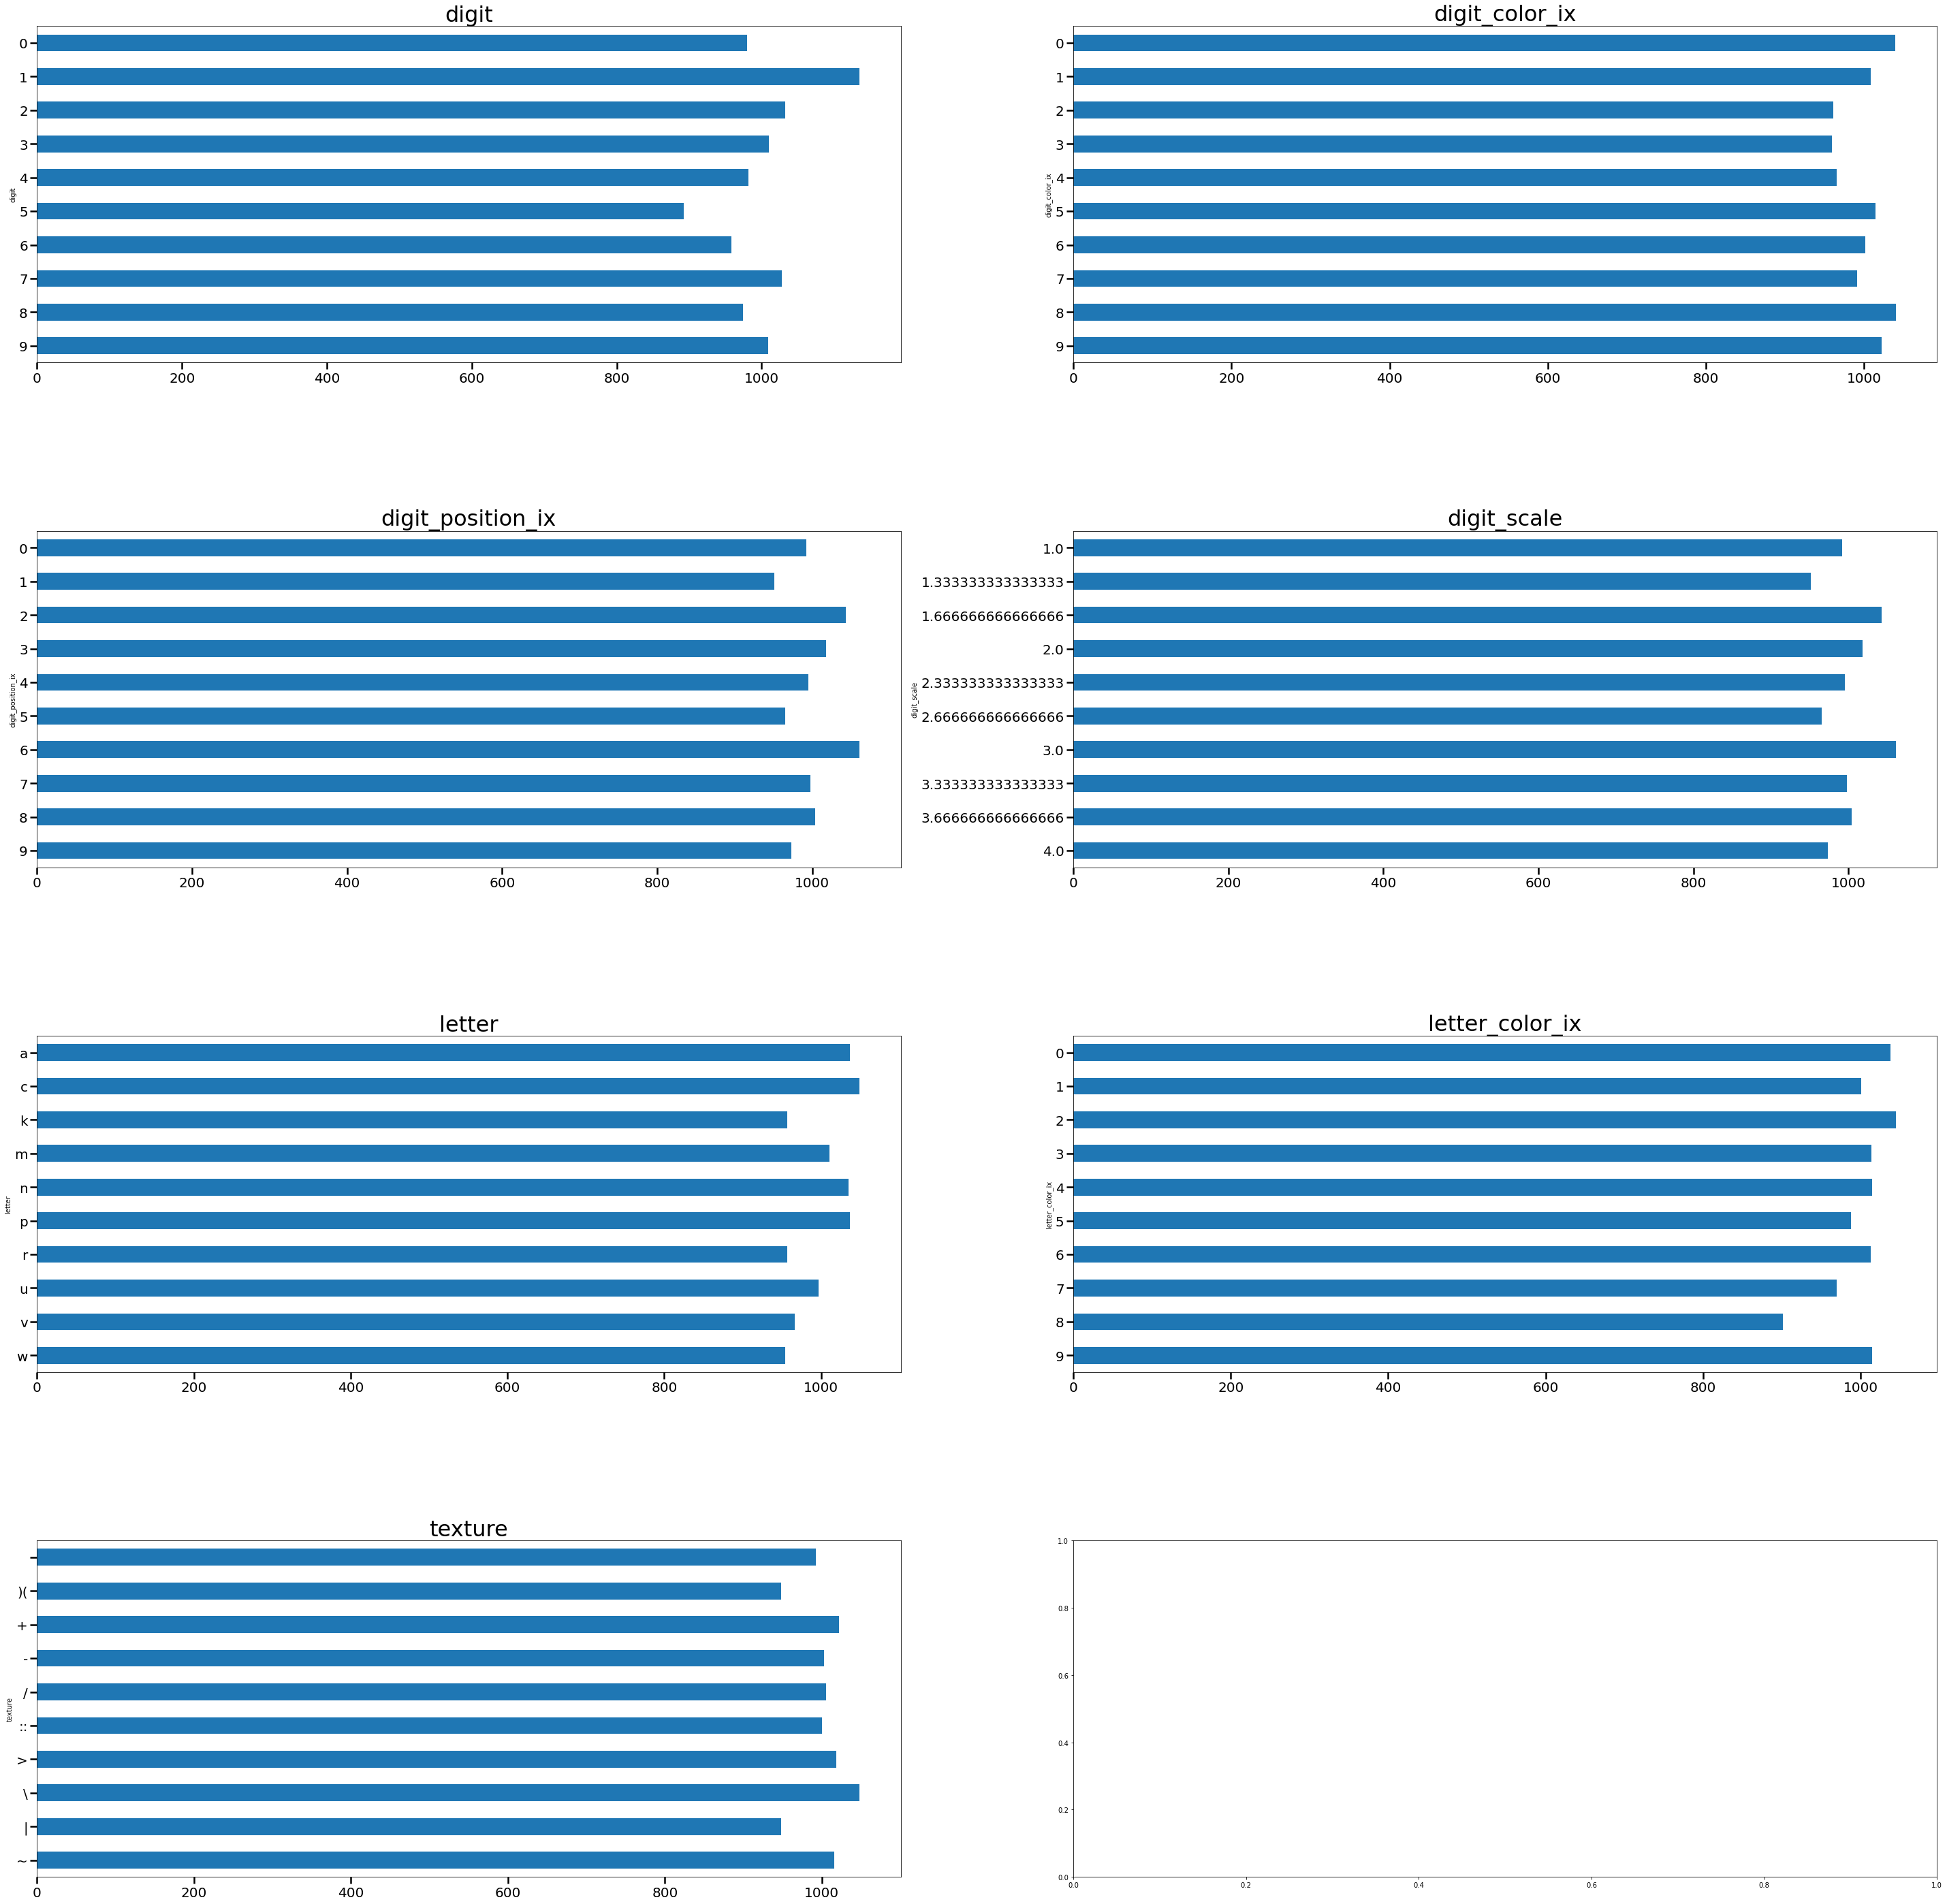

In [47]:
fig, axes = plt.subplots(4, 2, figsize=(50,50))

axes = axes.flatten()

for i, column in enumerate(biased_mnist_test):
    biased_mnist_test[column].value_counts().sort_index(ascending=False).plot(kind="barh", ax=axes[i])
    axes[i].set_title(column, fontsize=32)
    axes[i].tick_params(axis='both', which='major', labelsize=20, width=2.5, length=10)
    
plt.subplots_adjust(hspace=0.5)
plt.show()

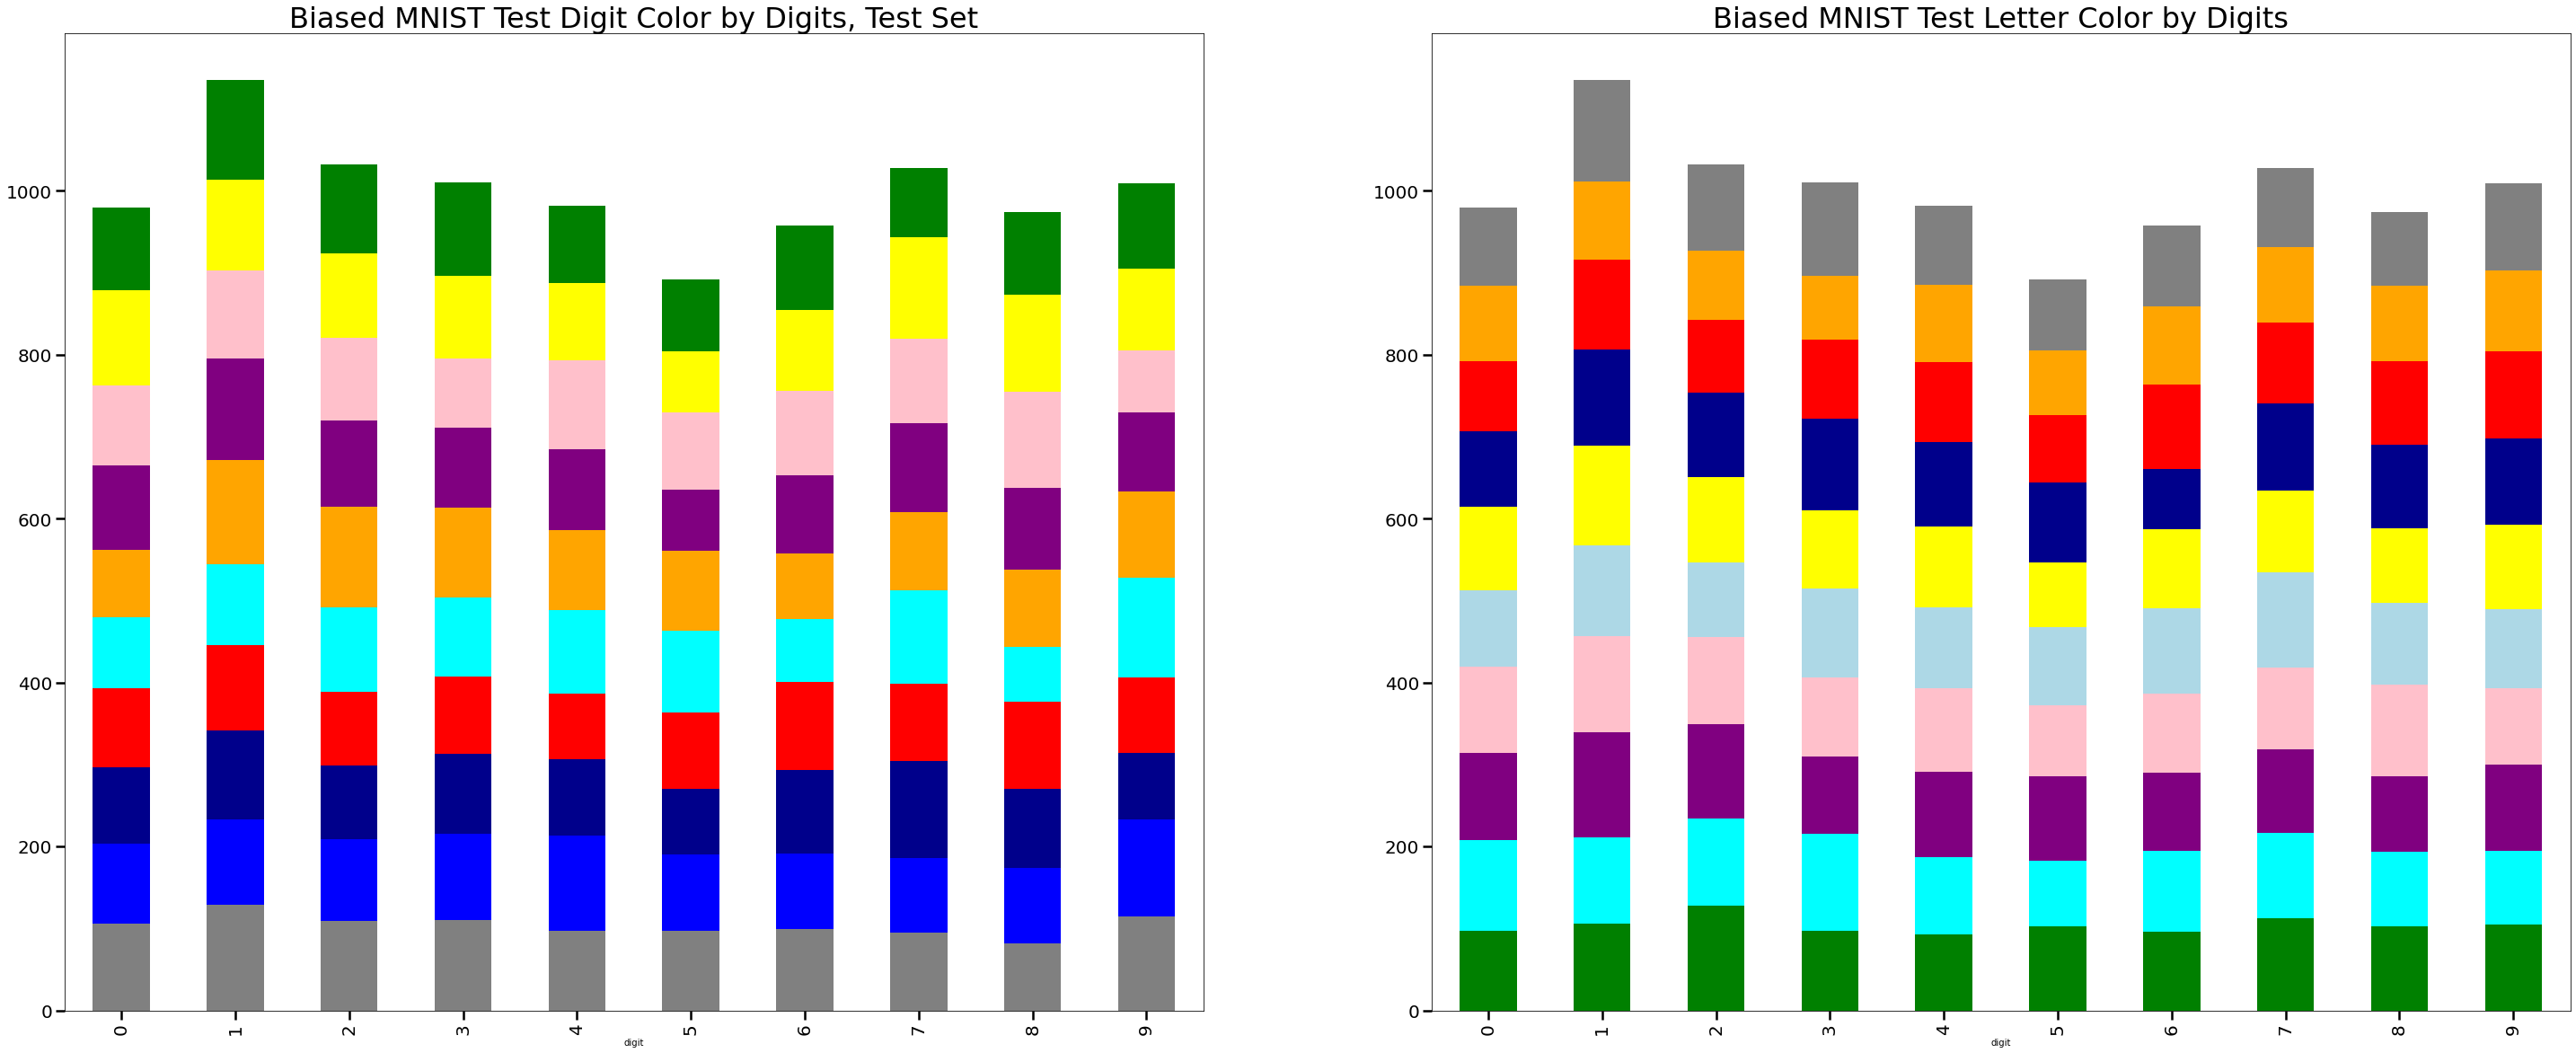

In [48]:
digit_color_dict = {9: "green", 5: "orange", 2: "darkblue", 1: "blue", 3: "red", 7: "pink", 8: "yellow", 0: "grey", 4: "cyan", 6: "purple"}
letter_color_dict = {9: "grey", 5: "yellow", 2: "purple", 1: "cyan", 3: "pink", 7: "red", 8: "orange", 0: "green", 4: "lightblue", 6: "darkblue"}

color_list = [digit_color_dict[i] for i in sorted(biased_mnist_test["digit_color_ix"].unique())]
letter_color_list = [letter_color_dict[i] for i in sorted(biased_mnist_test["letter_color_ix"].unique())]

fig, axes = plt.subplots(1, 2, figsize=(50,20))
axes = axes.flatten()

biased_mnist_test.groupby(by=['digit','digit_color_ix']).size().rename('count').unstack().plot(
    kind='bar', stacked=True, color=color_list, legend = None, ax=axes[0]
)
axes[0].set_title("Biased MNIST Test Digit Color by Digits, Test Set", fontsize=32)
axes[0].tick_params(axis='both', which='major', labelsize=20, width=2.5, length=10)

biased_mnist_test.groupby(by=['digit','letter_color_ix']).size().rename('count').unstack().plot(
    kind='bar', stacked=True, color=letter_color_list, legend = None, ax=axes[1]
)
axes[1].set_title("Biased MNIST Test Letter Color by Digits", fontsize=32)
axes[1].tick_params(axis='both', which='major', labelsize=20, width=2.5, length=10)

plt.show()

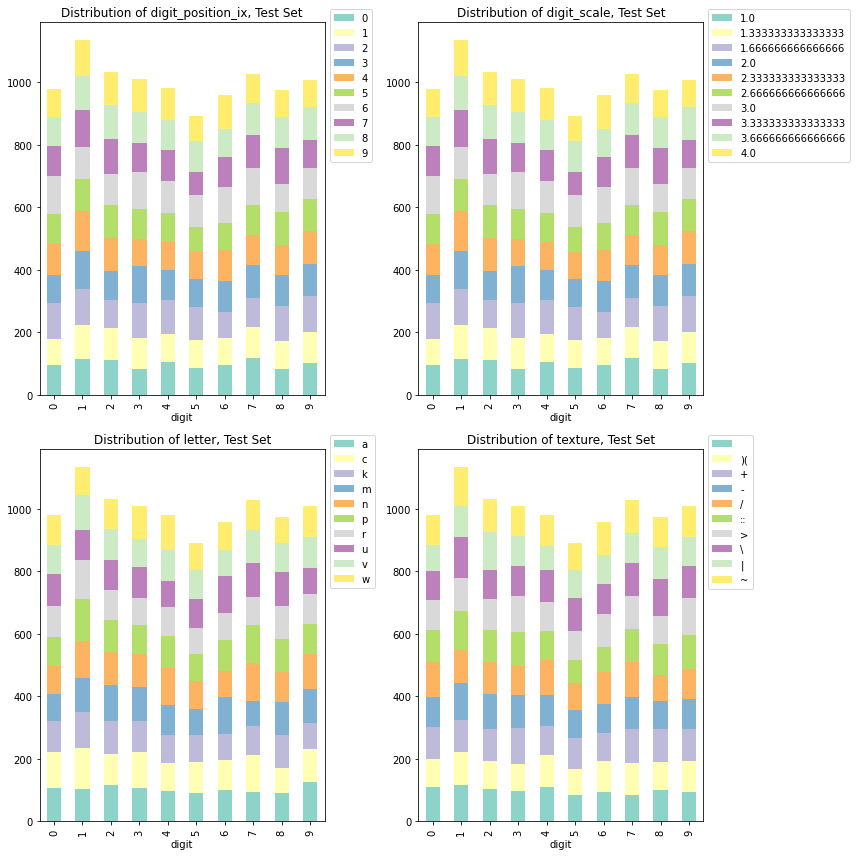

In [48]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

columns = ["digit_position_ix", "digit_scale", "letter", "texture"]

for i, column in enumerate(columns):
    ax = biased_mnist_test.groupby(by=['digit', column]).size().rename('count').unstack().plot(
        kind='bar', stacked=True, ax=axes[i], cmap="Set3"
    )
    ax.legend(bbox_to_anchor=(1, 1.05))
    ax.set_title(f"Distribution of {column}, Test Set", fontsize=12)

plt.tight_layout()
plt.show()

The test dataset contains very even distributions across all classes, which will be useful to test with. If we train our model on an extremely unbalanced dataset (like the 0.5 and 0.9 correlation datasets), it will struggle to classify a balanced dataset like this one. 

### Dimensionality Reduction - PCA

In [11]:
from mpl_toolkits.mplot3d import Axes3D
umap_df = pd.read_csv('/Users/leanne/Downloads/combined_umap.csv')
pacmap_df = pd.read_csv('/Users/leanne/Downloads/combined_pacmap.csv')
pca_df = pd.read_csv('/Users/leanne/Downloads/combined_pca.csv')
summary_df = pd.read_csv('/Users/leanne/Downloads/dataset_summary.csv')

<Figure size 864x720 with 0 Axes>

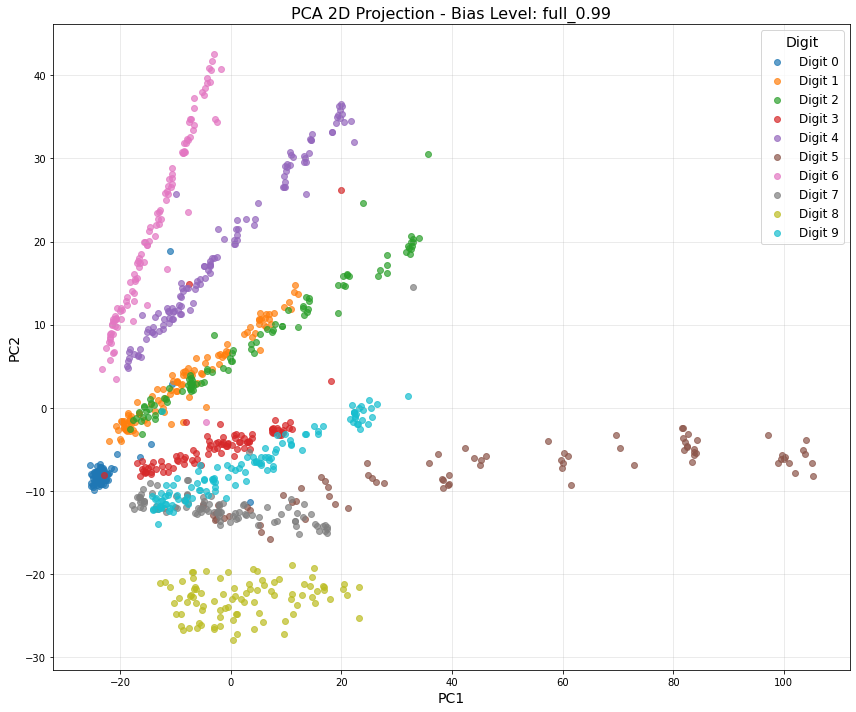

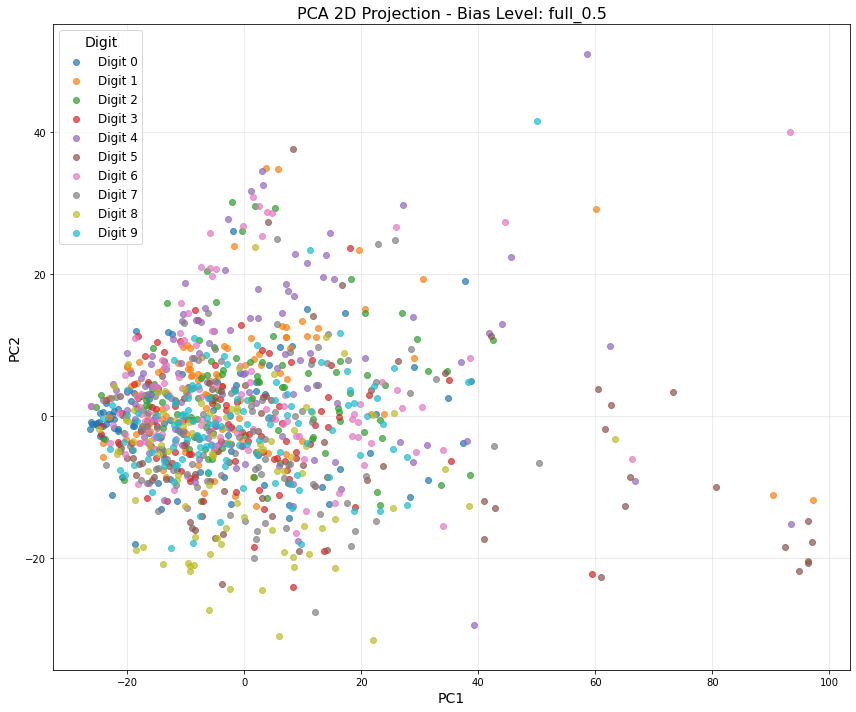

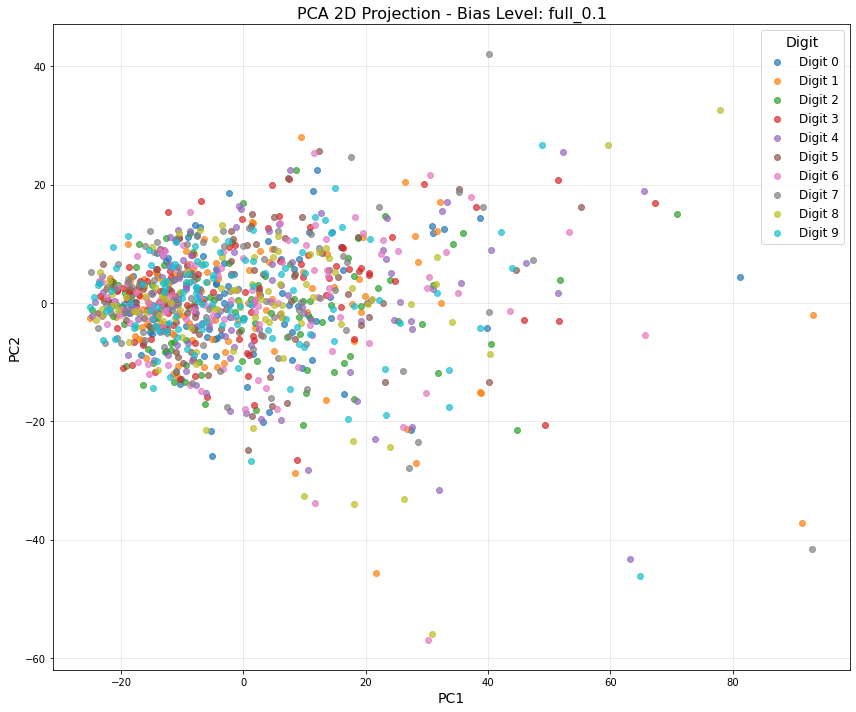

In [14]:
colors = plt.cm.tab10(np.linspace(0, 1, 10))

plt.figure(figsize=(12, 10))
for bias_level in pca_df['bias_level'].unique():
    plt.figure(figsize=(12, 10))
    subset = pca_df[pca_df['bias_level'] == bias_level]
    
    for label in sorted(subset['label'].unique()):
        mask = subset['label'] == label
        plt.scatter(subset[mask]['PC1'], subset[mask]['PC2'], 
                   c=[colors[label]], label=f'Digit {label}', alpha=0.7)
    
    plt.title(f'PCA 2D Projection - Bias Level: {bias_level}', fontsize=16)
    plt.xlabel('PC1', fontsize=14)
    plt.ylabel('PC2', fontsize=14)
    plt.legend(title='Digit', fontsize=12, title_fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'pca_2d_{bias_level}.png', dpi=300)

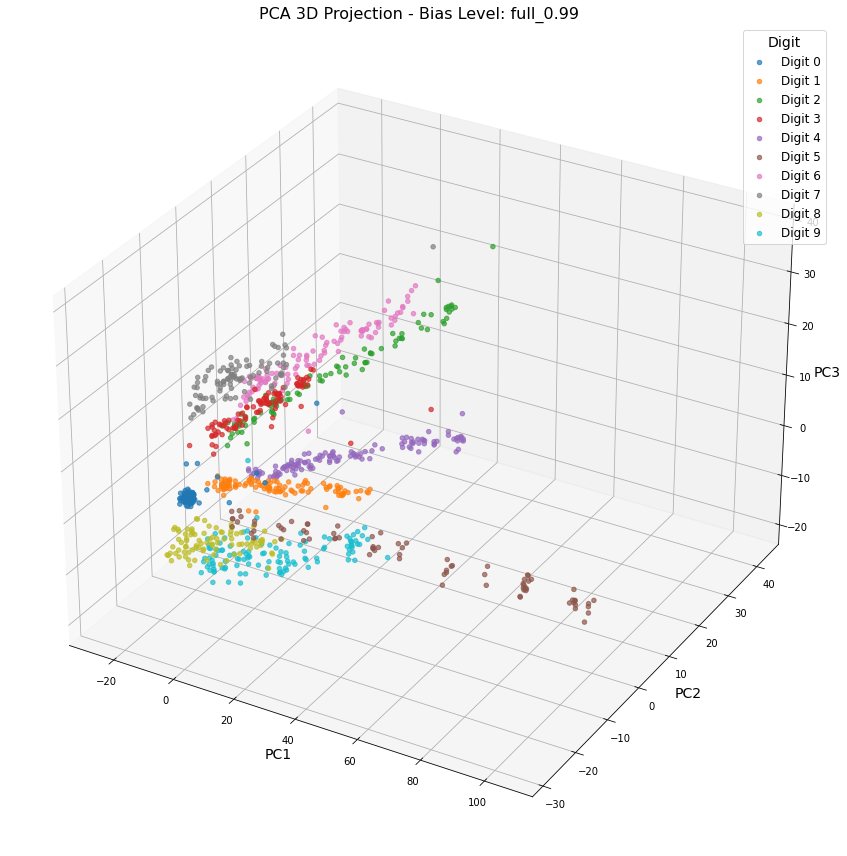

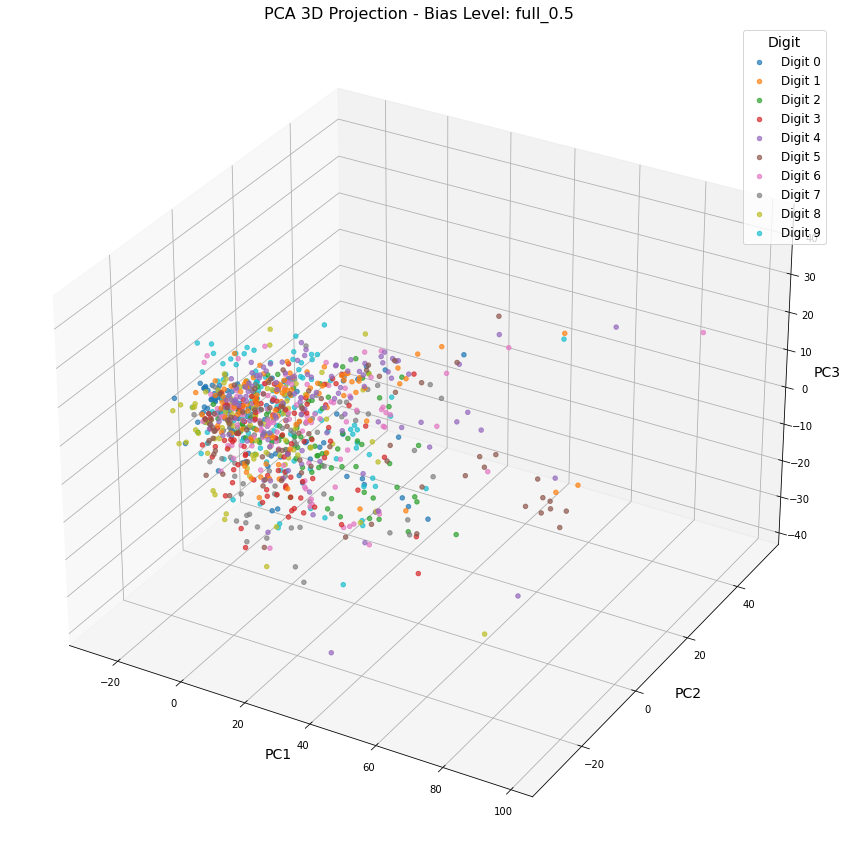

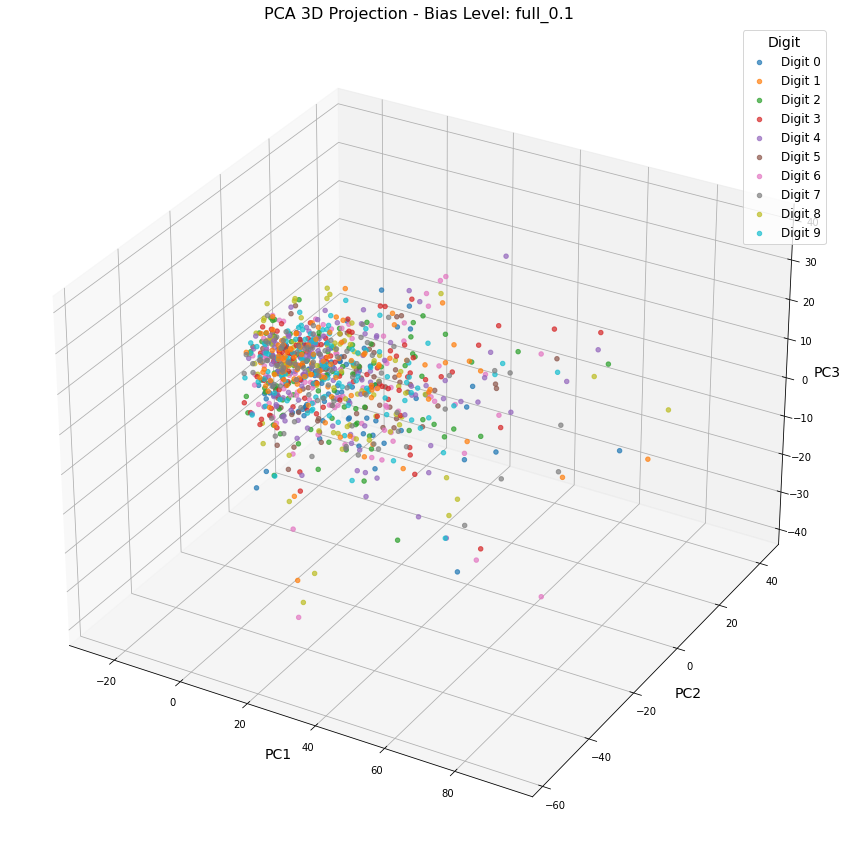

In [15]:
for bias_level in pca_df['bias_level'].unique():
    fig = plt.figure(figsize=(14, 12))
    ax = fig.add_subplot(111, projection='3d')
    subset = pca_df[pca_df['bias_level'] == bias_level]
    
    for label in sorted(subset['label'].unique()):
        mask = subset['label'] == label
        ax.scatter(subset[mask]['PC1'], subset[mask]['PC2'], subset[mask]['PC3'],
                  c=[colors[label]], label=f'Digit {label}', alpha=0.7)
    
    ax.set_title(f'PCA 3D Projection - Bias Level: {bias_level}', fontsize=16)
    ax.set_xlabel('PC1', fontsize=14)
    ax.set_ylabel('PC2', fontsize=14)
    ax.set_zlabel('PC3', fontsize=14)
    ax.legend(title='Digit', fontsize=12, title_fontsize=14)
    plt.tight_layout()
    plt.savefig(f'pca_3d_{bias_level}.png', dpi=300)

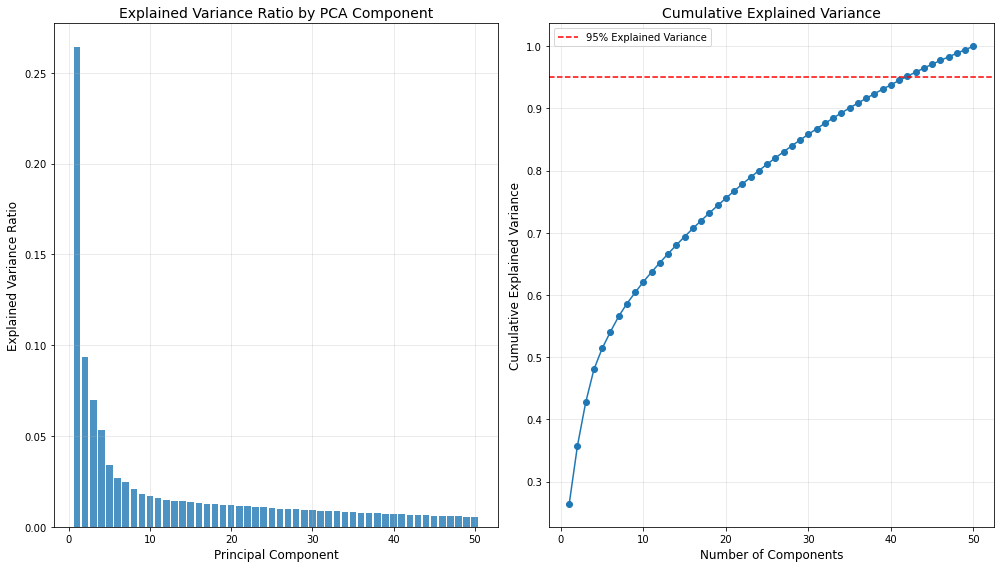

In [16]:
pca_columns = [col for col in pca_df.columns if col.startswith('PC') and col != 'PC1']
num_components = len(pca_columns) + 1  # Include PC1
explained_var = []

for i in range(1, num_components + 1):
    pc_col = f'PC{i}'
    if pc_col in pca_df.columns:
        variance = np.var(pca_df[pc_col])
        explained_var.append(variance)

explained_var = np.array(explained_var)
explained_var_ratio = explained_var / explained_var.sum()
cumulative_var_ratio = np.cumsum(explained_var_ratio)

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.bar(range(1, len(explained_var_ratio) + 1), explained_var_ratio, alpha=0.8)
plt.title('Explained Variance Ratio by PCA Component', fontsize=14)
plt.xlabel('Principal Component', fontsize=12)
plt.ylabel('Explained Variance Ratio', fontsize=12)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_var_ratio) + 1), cumulative_var_ratio, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.title('Cumulative Explained Variance', fontsize=14)
plt.xlabel('Number of Components', fontsize=12)
plt.ylabel('Cumulative Explained Variance', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('pca_explained_variance.png', dpi=300)

After performing PCA on each of the correlation datasets for MNIST, we can see that only the 0.99 dataset is clearly separable using PCA. Performing PCA on the 0.99 dataset yields distinct clusters of each digit, and this indicates that the majority of images for each digit look similar even when decomposed. This may be due to the fact that the majority of images with a certain digit have the same representation (same digit position, scale, color, texture etc) as we saw in the stacked bar charts above. The 0.5 and 0.1 datasets are not nearly as separable when using PCA.

### Dimensionality Reduction - UMAP

<Figure size 864x720 with 0 Axes>

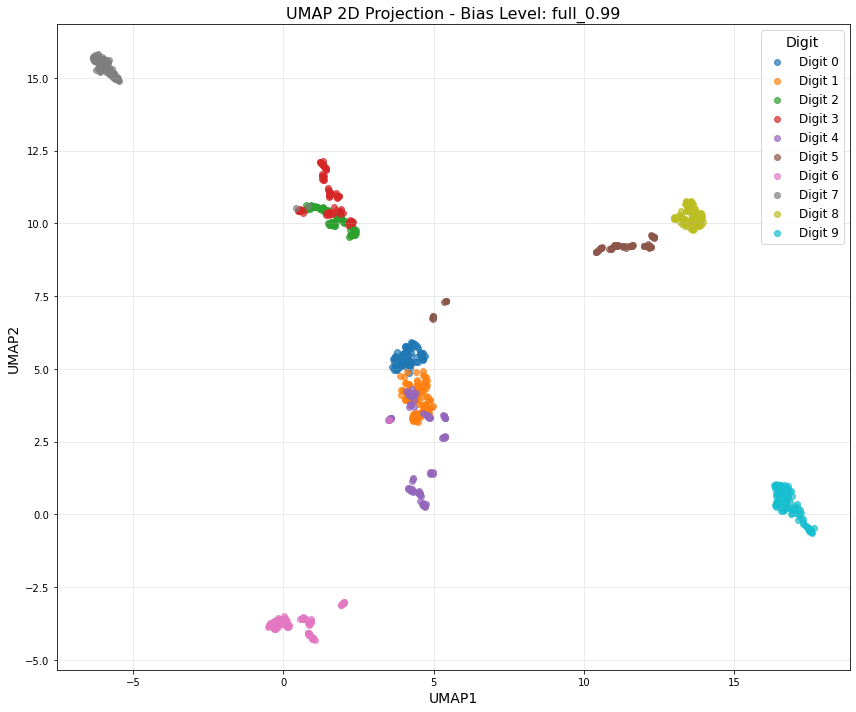

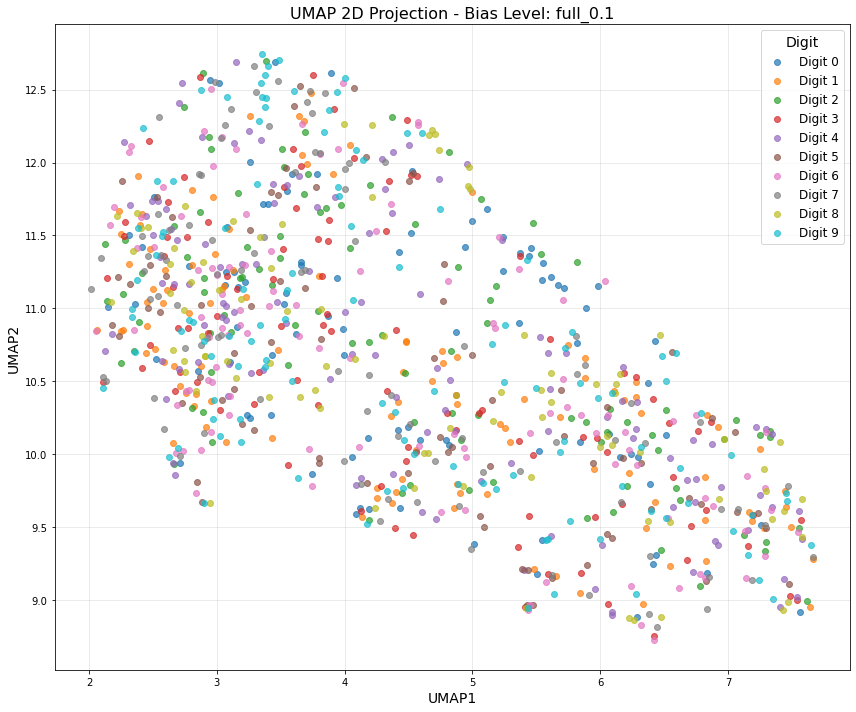

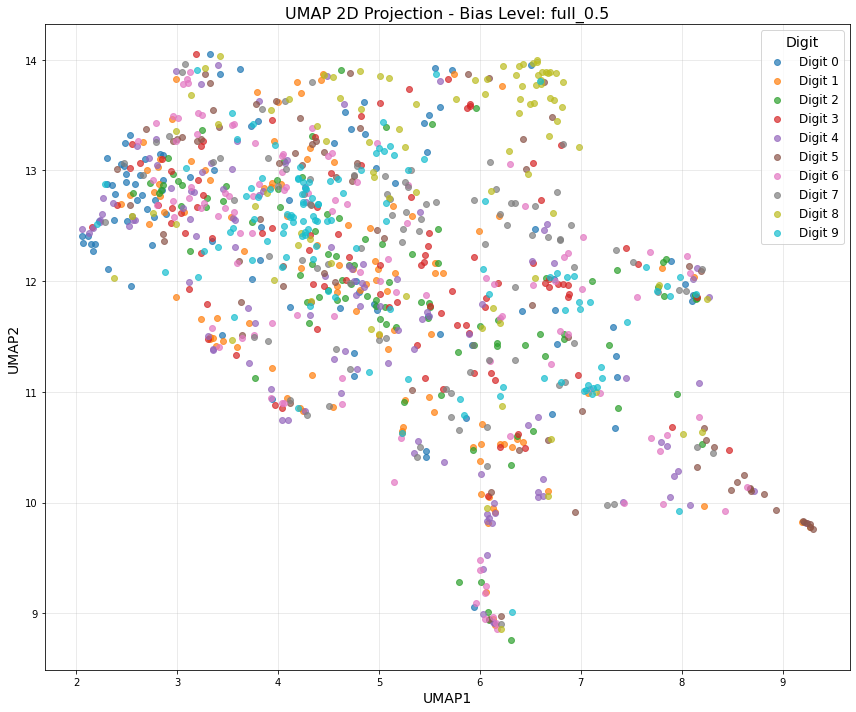

In [17]:
plt.figure(figsize=(12, 10))
for bias_level in umap_df['bias_level'].unique():
    plt.figure(figsize=(12, 10))
    subset = umap_df[umap_df['bias_level'] == bias_level]
    
    for label in sorted(subset['label'].unique()):
        mask = subset['label'] == label
        plt.scatter(subset[mask]['UMAP1'], subset[mask]['UMAP2'], 
                   c=[colors[label]], label=f'Digit {label}', alpha=0.7)
    
    plt.title(f'UMAP 2D Projection - Bias Level: {bias_level}', fontsize=16)
    plt.xlabel('UMAP1', fontsize=14)
    plt.ylabel('UMAP2', fontsize=14)
    plt.legend(title='Digit', fontsize=12, title_fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'umap_2d_{bias_level}.png', dpi=300)

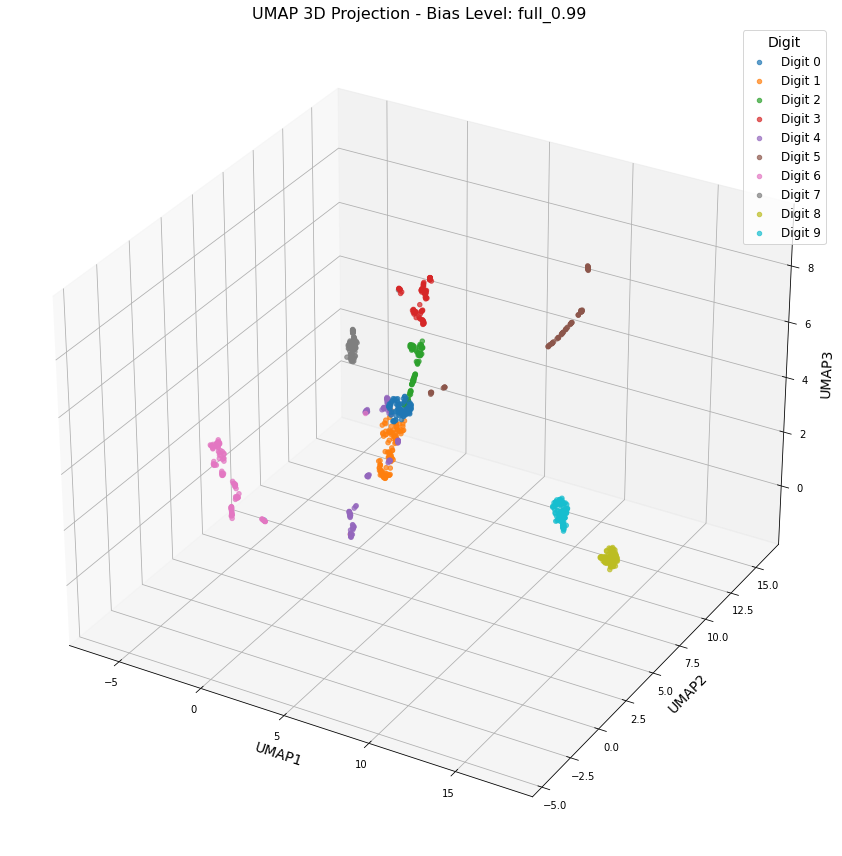

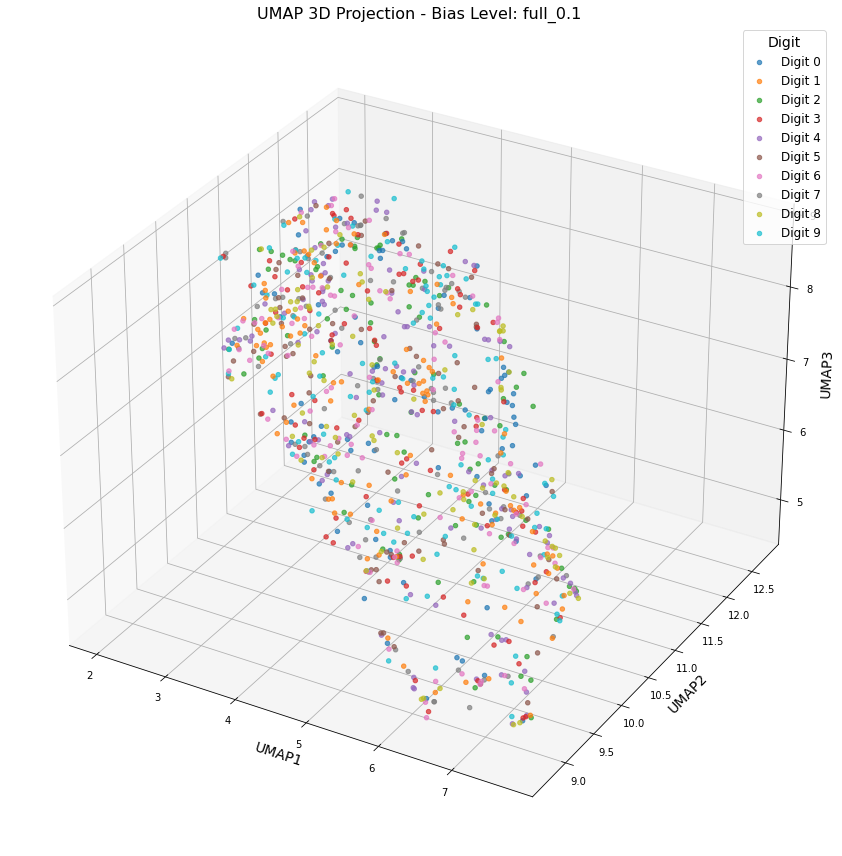

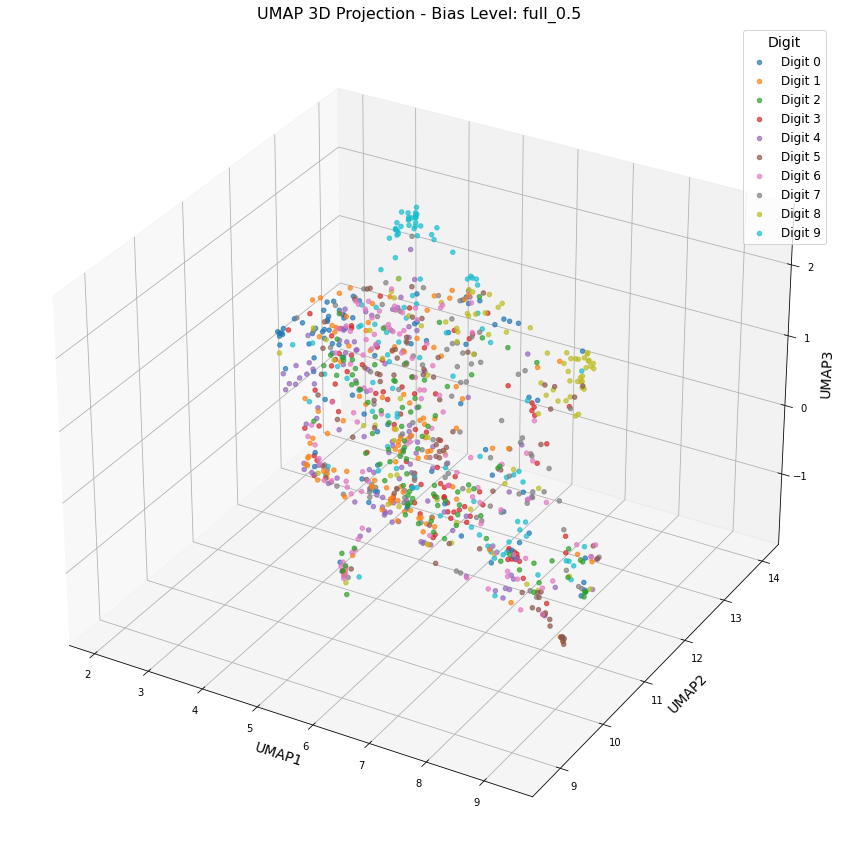

In [18]:
for bias_level in umap_df['bias_level'].unique():
    fig = plt.figure(figsize=(14, 12))
    ax = fig.add_subplot(111, projection='3d')
    subset = umap_df[umap_df['bias_level'] == bias_level]
    
    for label in sorted(subset['label'].unique()):
        mask = subset['label'] == label
        ax.scatter(subset[mask]['UMAP1'], subset[mask]['UMAP2'], subset[mask]['UMAP3'],
                  c=[colors[label]], label=f'Digit {label}', alpha=0.7)
    
    ax.set_title(f'UMAP 3D Projection - Bias Level: {bias_level}', fontsize=16)
    ax.set_xlabel('UMAP1', fontsize=14)
    ax.set_ylabel('UMAP2', fontsize=14)
    ax.set_zlabel('UMAP3', fontsize=14)
    ax.legend(title='Digit', fontsize=12, title_fontsize=14)
    plt.tight_layout()
    plt.savefig(f'umap_3d_{bias_level}.png', dpi=300)

Dimensionality reduction with UMAP yields identical findings to those discovered when using PCA. Only the 0.99 dataset images are highly separable using this technique, while 0.5 and 0.1 dataset images are very difficult to separate using this dimensionality technique. Again, this is likely due to the high correlation of other variables with digit number in the 0.99 dataset, which results in the images of each digit looking very similar and making them easier to distinguish. From the visualizations, we can also see that digits 2 and 3 look very similar to each other, while 0, 1, and 4 also are difficult to distinguish when decomposed with UMAP.

### Dimensionality Reduction - PaCMAP

<Figure size 864x720 with 0 Axes>

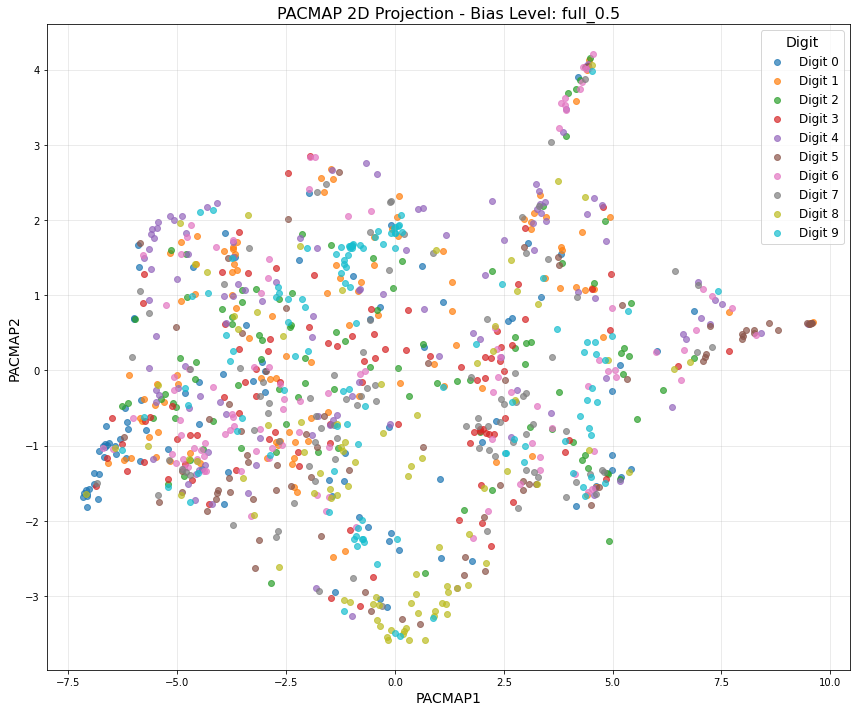

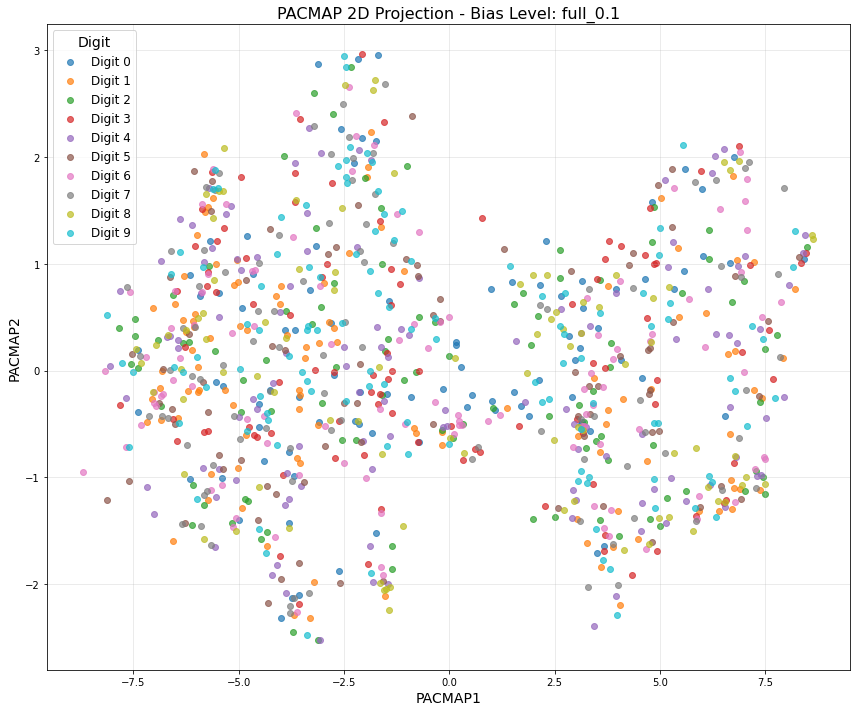

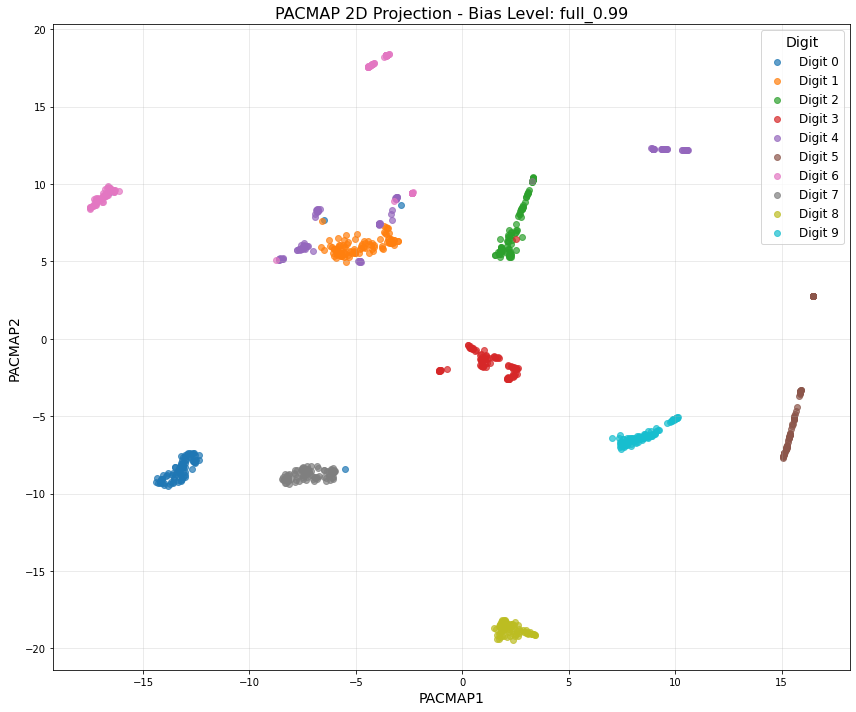

In [19]:
plt.figure(figsize=(12, 10))
for bias_level in pacmap_df['bias_level'].unique():
    plt.figure(figsize=(12, 10))
    subset = pacmap_df[pacmap_df['bias_level'] == bias_level]
    
    for label in sorted(subset['label'].unique()):
        mask = subset['label'] == label
        plt.scatter(subset[mask]['PACMAP1'], subset[mask]['PACMAP2'], 
                   c=[colors[label]], label=f'Digit {label}', alpha=0.7)
    
    plt.title(f'PACMAP 2D Projection - Bias Level: {bias_level}', fontsize=16)
    plt.xlabel('PACMAP1', fontsize=14)
    plt.ylabel('PACMAP2', fontsize=14)
    plt.legend(title='Digit', fontsize=12, title_fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'pacmap_2d_{bias_level}.png', dpi=300)

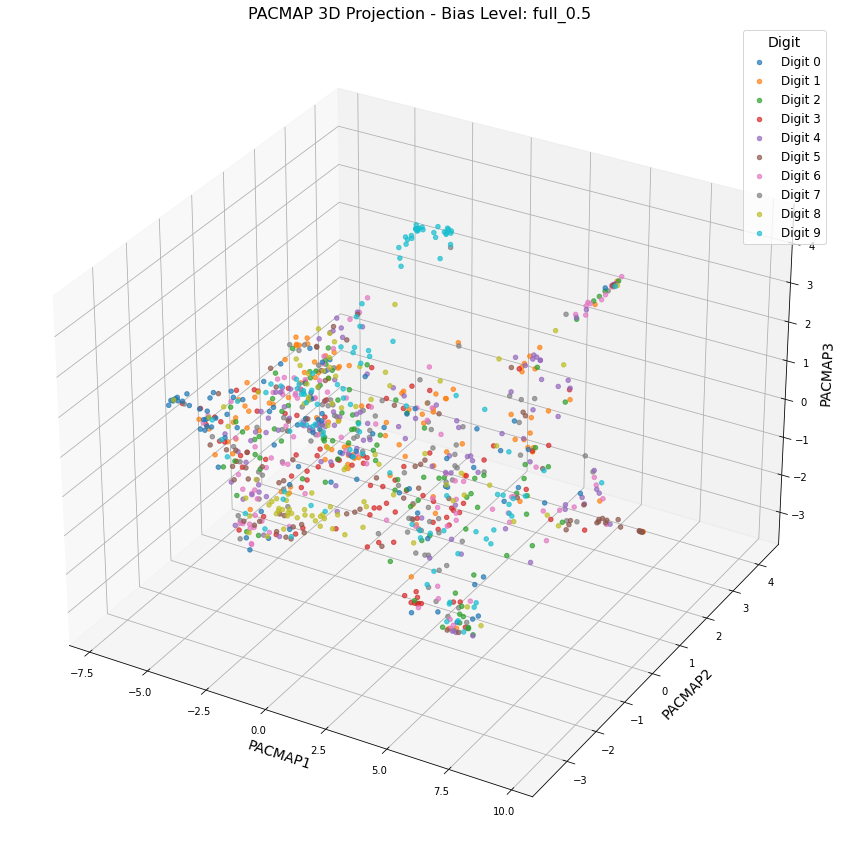

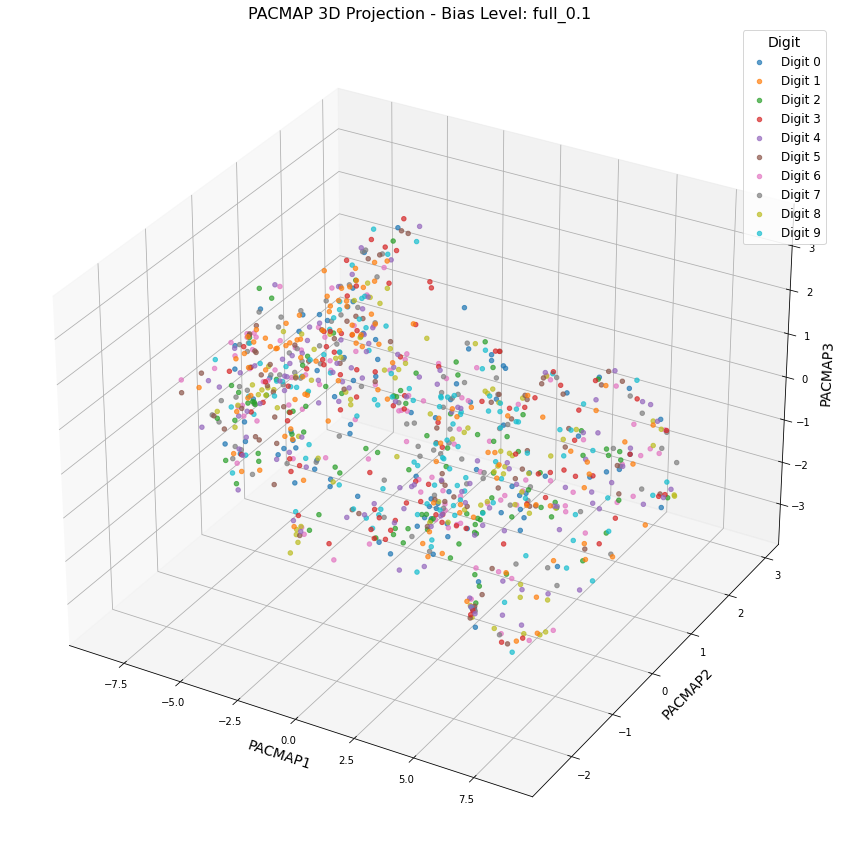

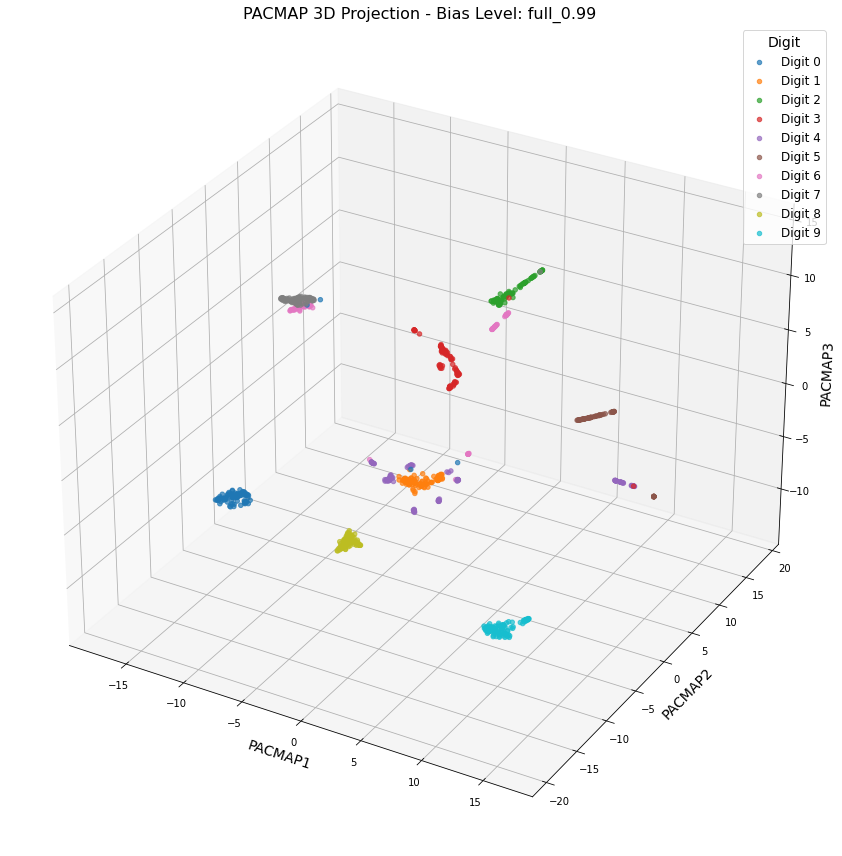

In [20]:
for bias_level in pacmap_df['bias_level'].unique():
    fig = plt.figure(figsize=(14, 12))
    ax = fig.add_subplot(111, projection='3d')
    subset = pacmap_df[pacmap_df['bias_level'] == bias_level]
    
    for label in sorted(subset['label'].unique()):
        mask = subset['label'] == label
        ax.scatter(subset[mask]['PACMAP1'], subset[mask]['PACMAP2'], subset[mask]['PACMAP3'],
                  c=[colors[label]], label=f'Digit {label}', alpha=0.7)
    
    ax.set_title(f'PACMAP 3D Projection - Bias Level: {bias_level}', fontsize=16)
    ax.set_xlabel('PACMAP1', fontsize=14)
    ax.set_ylabel('PACMAP2', fontsize=14)
    ax.set_zlabel('PACMAP3', fontsize=14)
    ax.legend(title='Digit', fontsize=12, title_fontsize=14)
    plt.tight_layout()
    plt.savefig(f'pacmap_3d_{bias_level}.png', dpi=300)

Again, our findings using the previous two dimensionality reduction techniques are supported using PaCMAP. The 0.99 dataset is again very separated, while the 0.5 and 0.1 datasets are not. The 0.5 dataset shows some additional separation between digits, although it is not very much. The separation between digits also appears to be the highest out of all three dimensionality reduction techniques using PaCMAP. PaCMAP indicates that 6 and 7 look similar when decomposed, as well as 4 and 1.

In [4]:
!jupyter nbconvert --output-dir='/Users/leanne/Documents/WSU/DATA424' --no-input --to pdf T2P4_Exploratory_Data_Analysis.ipynb

[NbConvertApp] Converting notebook T2P4_Exploratory_Data_Analysis.ipynb to pdf
[NbConvertApp] Support files will be in T2P4_Exploratory_Data_Analysis_files/
[NbConvertApp] Making directory ./T2P4_Exploratory_Data_Analysis_files
[NbConvertApp] Making directory ./T2P4_Exploratory_Data_Analysis_files
[NbConvertApp] Making directory ./T2P4_Exploratory_Data_Analysis_files
[NbConvertApp] Making directory ./T2P4_Exploratory_Data_Analysis_files
[NbConvertApp] Making directory ./T2P4_Exploratory_Data_Analysis_files
[NbConvertApp] Making directory ./T2P4_Exploratory_Data_Analysis_files
[NbConvertApp] Making directory ./T2P4_Exploratory_Data_Analysis_files
[NbConvertApp] Making directory ./T2P4_Exploratory_Data_Analysis_files
[NbConvertApp] Making directory ./T2P4_Exploratory_Data_Analysis_files
[NbConvertApp] Making directory ./T2P4_Exploratory_Data_Analysis_files
[NbConvertApp] Making directory ./T2P4_Exploratory_Data_Analysis_files
[NbConvertApp] Making directory ./T2P4_Exploratory_Data_Analys